<a href="https://colab.research.google.com/github/SergeiVKalinin/Research-Projects/blob/main/EELS/VAE_EELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders for the analysis of spectral data

This notebook illustrates the analysis of the hyperspectral data using the simple, conditional, joint, and semi-supervised Variartional Autoencoders. Here, we use the Electron Energy Loss Spectroscopy (EELS) data on plasmonic nanostructures. However, the code can be used without change for other hyperspectral data sets such as CITS in Scanning Tunneling Microscopy, Force-distance curves in Atomic Force Microscopy, and other spectroscopic methods.

- Workflow by Sergei Kalinin, https://scholar.google.com/citations?user=-cuxoSQAAAAJ, E-mail: sergei2@utk.edu
- Data by Kevin Roccapriore, https://scholar.google.com/citations?hl=en&user=PJwlbBIAAAAJ
- Samples were originally made by Delia Milliron group, https://scholar.google.com/citations?hl=en&user=VMuYx0t0ImcC
- PyroVED library by Maxim Ziatdinov https://scholar.google.com/citations?hl=en&user=YnSdOoUAAAAJ
- To convert the instrument-specific data to Numpy format that can be used in this notebook, you can use the PyCroscopy ecosystem by Rama Vasudevan (https://scholar.google.com/citations?user=b2XP9A4AAAAJ&hl=en&oi=ao), https://github.com/pycroscopy/pycroscopy

Installations:

In [ ]:
#!pip install atomai pyroved
#!pip install -q git+https://github.com/ziatdinovmax/pyroVED@main
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


Imports:

In [ ]:
from copy import deepcopy as dc

import numpy as np
import torch

from skimage.feature import blob_dog, blob_log, blob_doh
from scipy import fftpack, ndimage
import cv2

from sklearn import decomposition
from sklearn.cluster import MeanShift
from sklearn.ensemble import IsolationForest

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pyroved as pv
#import atomai as aoi

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [ ]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

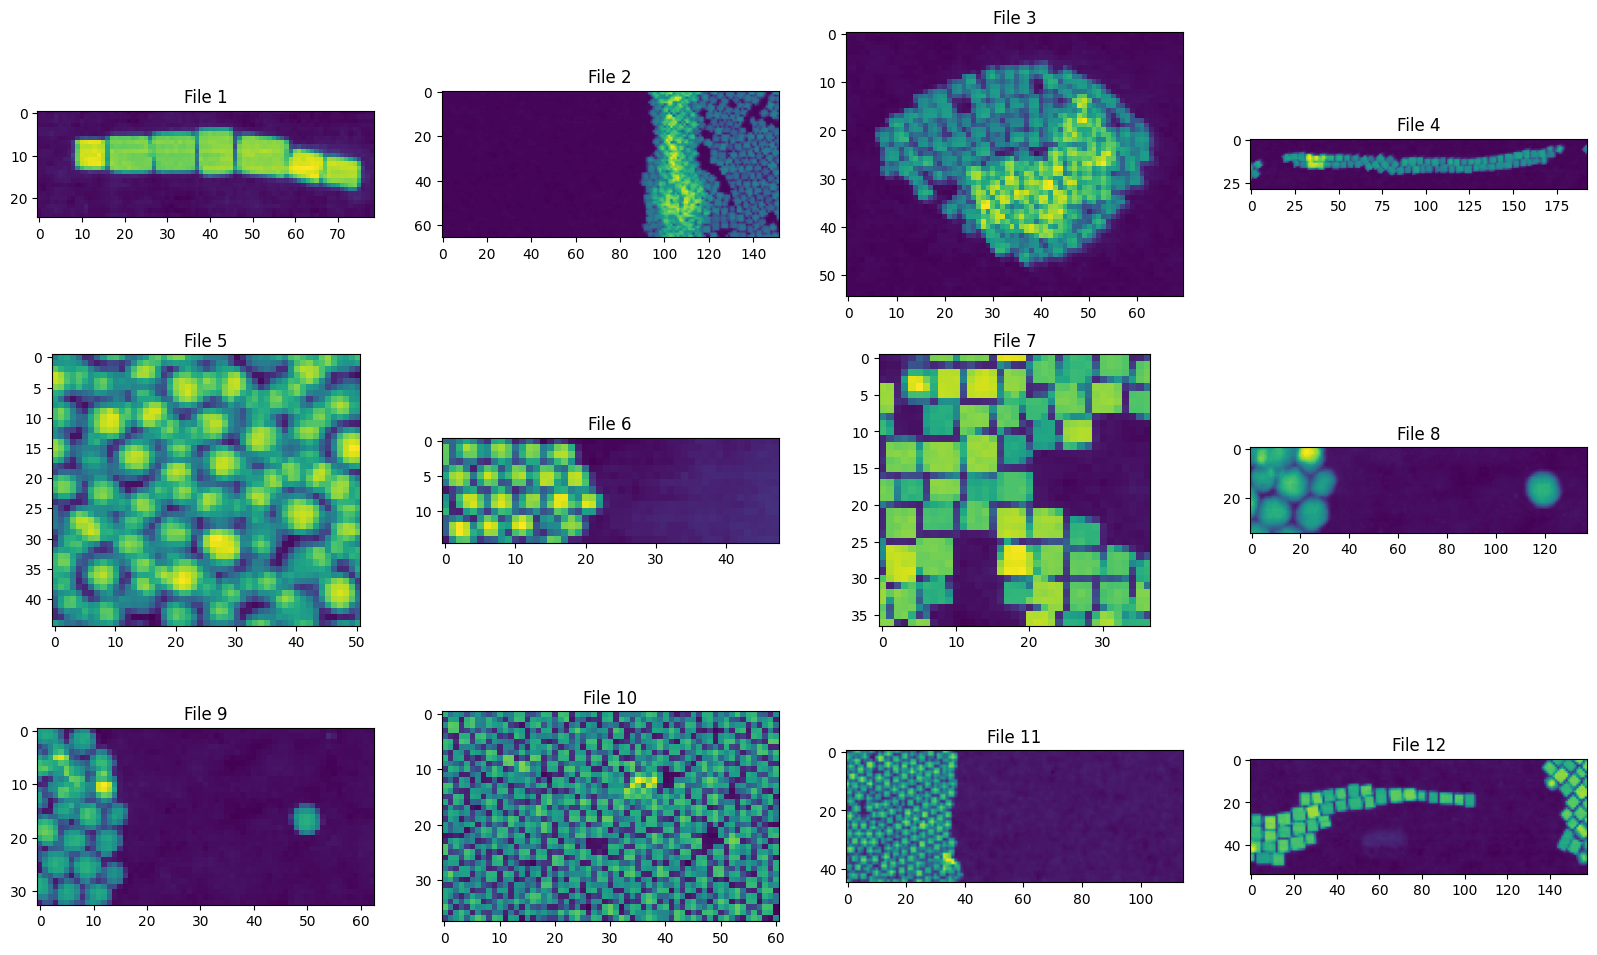

In [ ]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows)))

for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [ ]:
# Choose the file for analysis

k = 9
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [ ]:
'''
#@title Helper functions
def sub_plane(img):
    """Subtracts plane"""
    X1, X2 = np.mgrid[:img.shape[0], :img.shape[1]]
    X1, X2 = X1.reshape(-1,1), X2.reshape(-1,1)
    Y = img.reshape(img.shape[0]*img.shape[1], 1)
    Y = (Y - np.amin(Y))/np.ptp(Y)
    X = np.concatenate(
        (np.ones((X1.shape[0], 1)), X1, X2), axis = 1)
    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
    plane = np.dot(X, theta).reshape(img.shape[0], img.shape[1]);
    Y_sub = Y.reshape(img.shape[0],img.shape[1]) - plane
    return Y_sub
    '''

'\n#@title Helper functions\ndef sub_plane(img):\n    """Subtracts plane"""\n    X1, X2 = np.mgrid[:img.shape[0], :img.shape[1]]\n    X1, X2 = X1.reshape(-1,1), X2.reshape(-1,1)\n    Y = img.reshape(img.shape[0]*img.shape[1], 1)\n    Y = (Y - np.amin(Y))/np.ptp(Y)\n    X = np.concatenate(\n        (np.ones((X1.shape[0], 1)), X1, X2), axis = 1)\n    theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)\n    plane = np.dot(X, theta).reshape(img.shape[0], img.shape[1]);\n    Y_sub = Y.reshape(img.shape[0],img.shape[1]) - plane\n    return Y_sub\n    '

In [ ]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

'''
# Read topography
topo = img
topo = sub_plane(topo)
print(hdata.shape, topo.shape)
'''

'\n# Read topography\ntopo = img\ntopo = sub_plane(topo)\nprint(hdata.shape, topo.shape)\n'

Visual inspection of the :

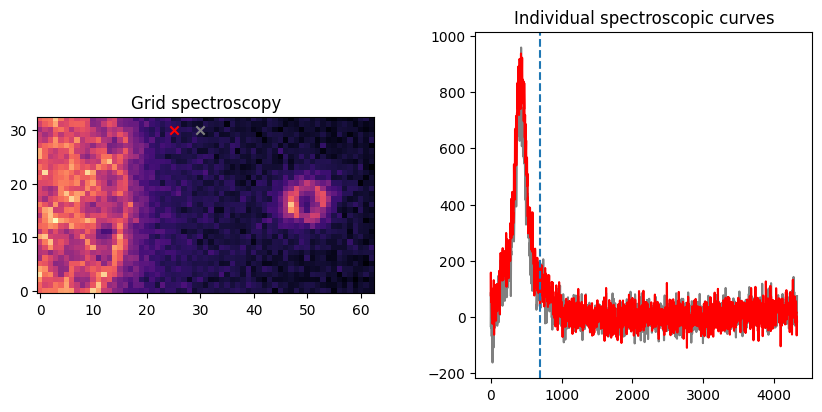

In [ ]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 700 # slice
pos1 = [30, 30]
pos2 = [25, 30]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Very important considerations for subsequent analysis.
 - Make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zerol-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool).
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted.
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or worng way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

# PCA and NMF

As a first step, it is always a good idea to perform exploratory data analysis. Here, we use the standard principal component analysis and non-negative matrix factorization.

In [ ]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

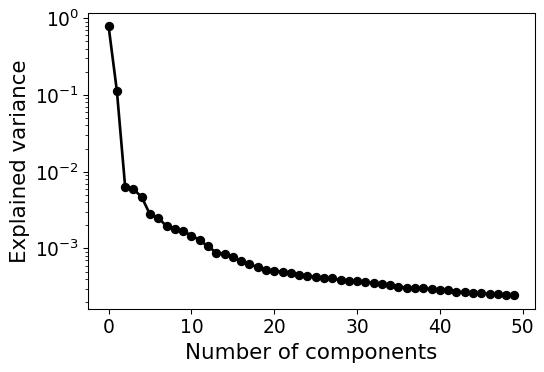

In [ ]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.figure(figsize=(6, 4), dpi = 96)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c = 'black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)

plt.tick_params(labelsize = 14)
plt.yscale('log')

In [ ]:
# Select number of components
nc = 20

# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'PCA'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(20, 4322) (2079, 20)


NUMBER OF COMPONENTS: 20
Components...


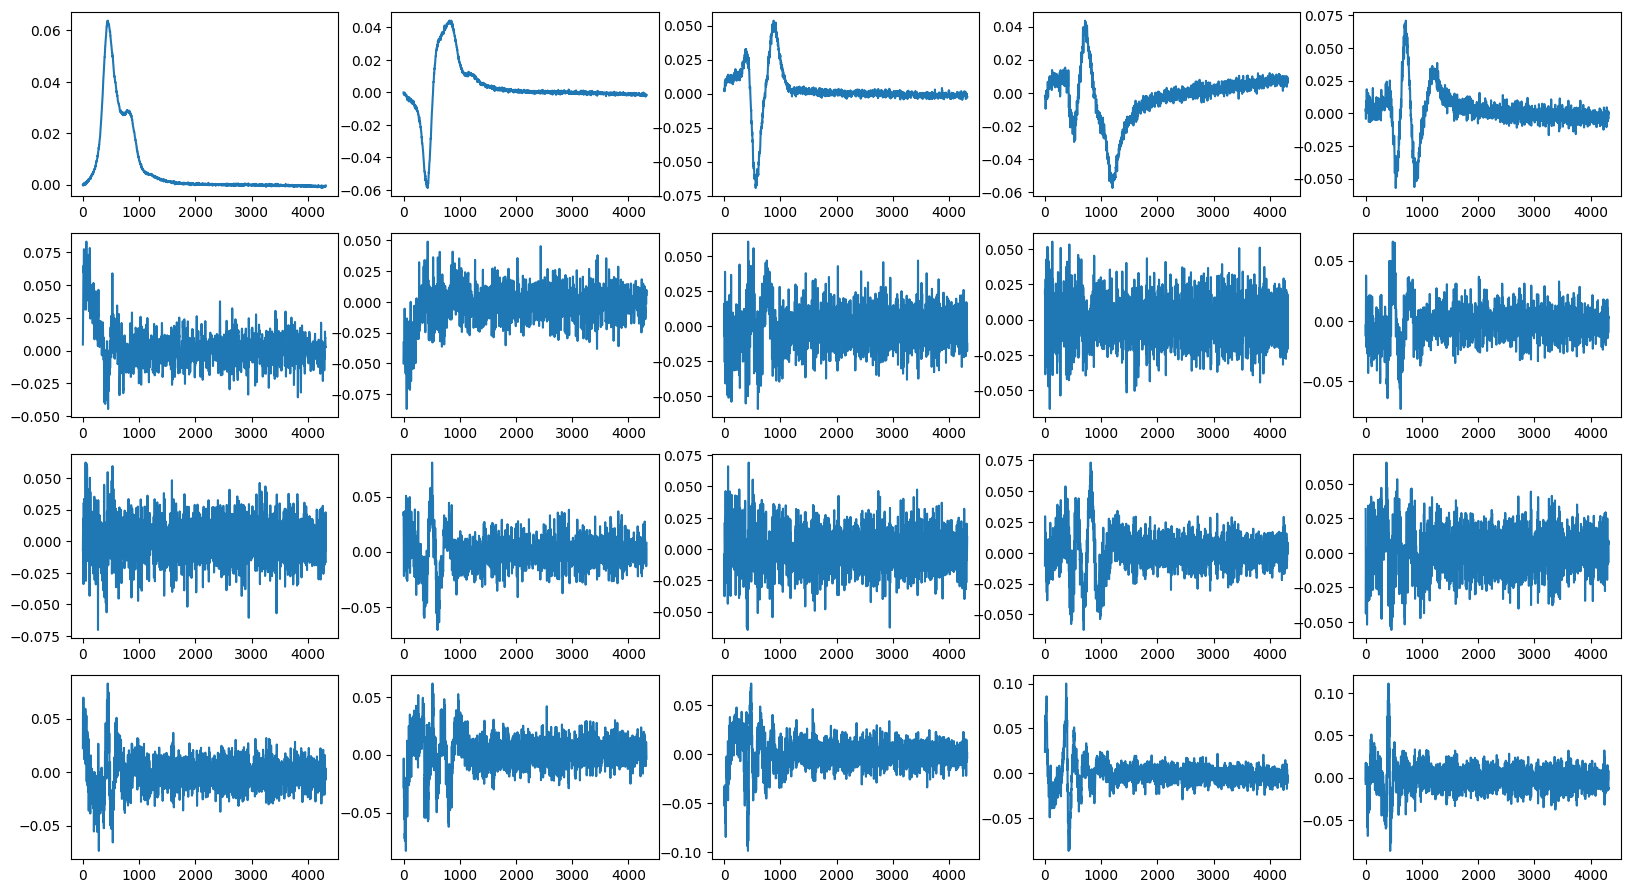

Abundance maps...


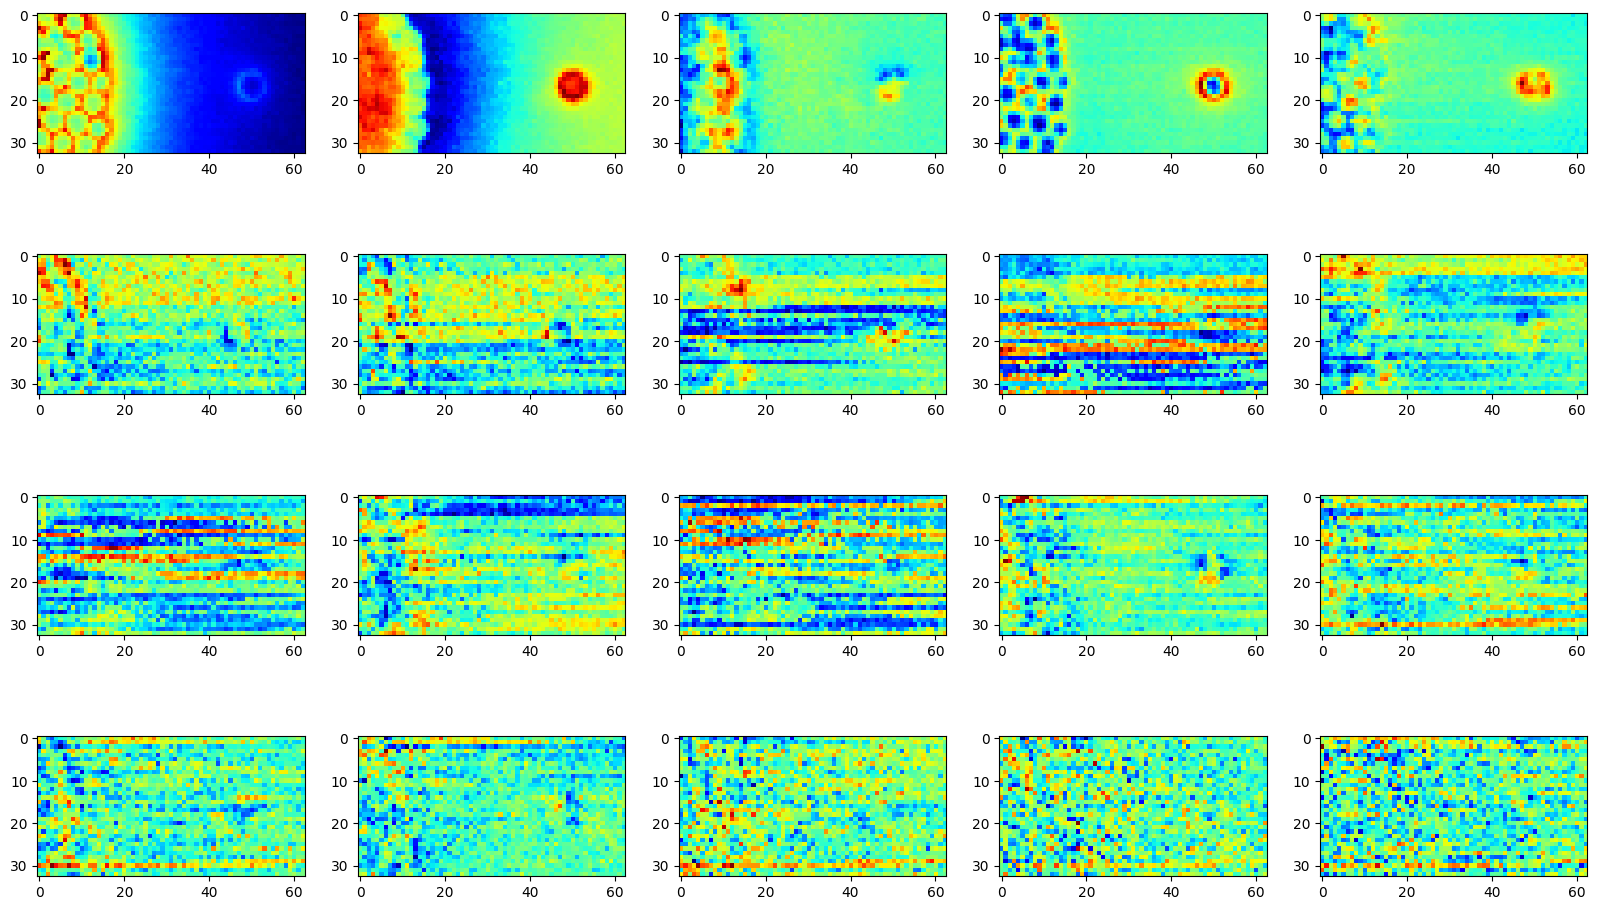

In [ ]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    ax1.plot(components[i])
    #ax1.set_title('Component ' + str(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    #ax2.set_title('Component ' + str(i + 1))
plt.show()

We are bot going to go through the details of the PCA/NMF here. However, it is always a good idea to explore these, both component and loading maps, as a first step in any analysis. Also, for EELS that allows to check for presence of the cosmic ray noise.

# VAE analysis

Here, we perform the simple VAE analysis of the EELS dataset, training the VAE with 2 and 3D latent space, visualizing latent distributions and latent representations, and latent coefficient maps.

The relevant publications is:
https://arxiv.org/abs/2104.10207

In [ ]:
specim.shape
hdata = specim


In [ ]:
#Let's flatten the data

s1, s2, s3 = hdata.shape
hdata = hdata.reshape(s1*s2, s3)

In [ ]:
# Keep track of normalization!

# This is full normalization
#hdata = hdata - hdata.mean(axis = 0)
#hdata = (hdata-hdata.min())/(hdata.max()-hdata.min())

# This is normalization by maximum
hdata = (hdata-hdata.min())/(hdata.max()-hdata.min())

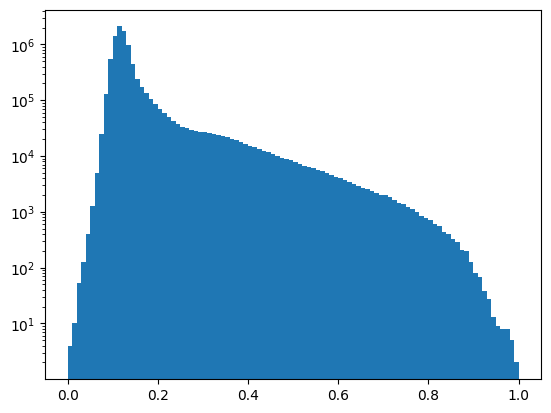

In [ ]:
# Check the histogram. This allows to establish the presence of strong outliers

plt.hist(hdata.flatten(), bins=100);
plt.semilogy();

In [ ]:
train_data = hdata

#n_samples = train_data.shape[0] # number of samples
l_signal = train_data.shape[1] # signal length

train_data = torch.tensor(train_data).float()
x = torch.linspace(-5, 5, l_signal)

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data, batch_size=64)

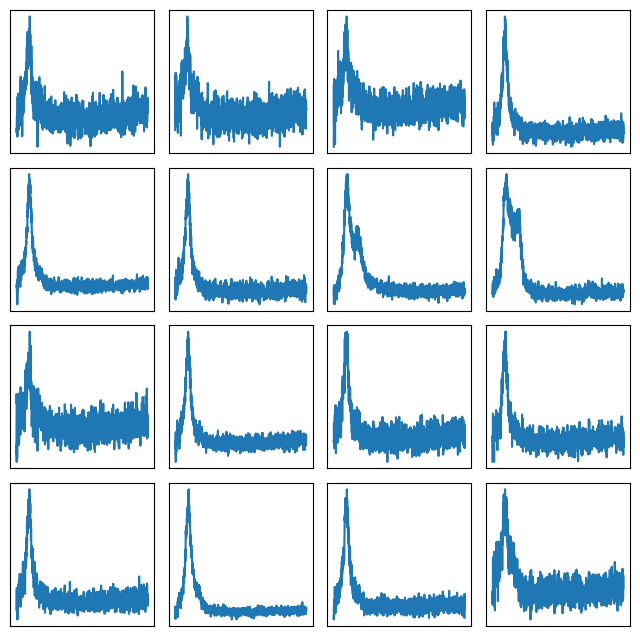

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0])
    # ax.set_ylim(0.25, 0.33)

Our goal is to find the real/physical descriptor of the data set in an unsupervised fashion. First, let's train a regular VAE:

### 2D latent space

In [ ]:
in_dim = (l_signal,)

# Initialize vanilla VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(50):
    trainer.step(train_loader, scale_factor=1)
    trainer.print_statistics()

Epoch: 1 Training loss: 904733.5493
Epoch: 2 Training loss: 60827.2311
Epoch: 3 Training loss: 35737.1019
Epoch: 4 Training loss: 34465.9196
Epoch: 5 Training loss: 34525.4531
Epoch: 6 Training loss: 34376.8964
Epoch: 7 Training loss: 34485.6569
Epoch: 8 Training loss: 34253.9524
Epoch: 9 Training loss: 33009.4542
Epoch: 10 Training loss: 24288.4011
Epoch: 11 Training loss: 2168.2149
Epoch: 12 Training loss: -3054.2470
Epoch: 13 Training loss: -4528.3897
Epoch: 14 Training loss: -4718.2566
Epoch: 15 Training loss: -4536.5932
Epoch: 16 Training loss: -4836.1059
Epoch: 17 Training loss: -4895.4169
Epoch: 18 Training loss: -4967.8542
Epoch: 19 Training loss: -5012.6395
Epoch: 20 Training loss: -4982.8251
Epoch: 21 Training loss: -5112.2682
Epoch: 22 Training loss: -5203.2985
Epoch: 23 Training loss: -5415.6713
Epoch: 24 Training loss: -5510.0901
Epoch: 25 Training loss: -5619.6159
Epoch: 26 Training loss: -5740.5266
Epoch: 27 Training loss: -5725.7085
Epoch: 28 Training loss: -5809.3673
E

Encode the training data into the latent space:

Text(0, 0.5, '$z_1$')

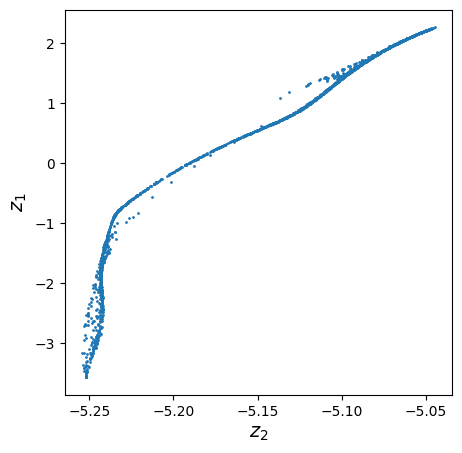

In [ ]:
z_mean, z_sd = vae.encode(train_data)

plt.figure(figsize=(5, 5))
plt.scatter(z_mean[:, -1], z_mean[:, -2], s=1)
plt.xlabel("$z_2$", fontsize=14)
plt.ylabel("$z_1$", fontsize=14)

Plot the learned latent manifold:

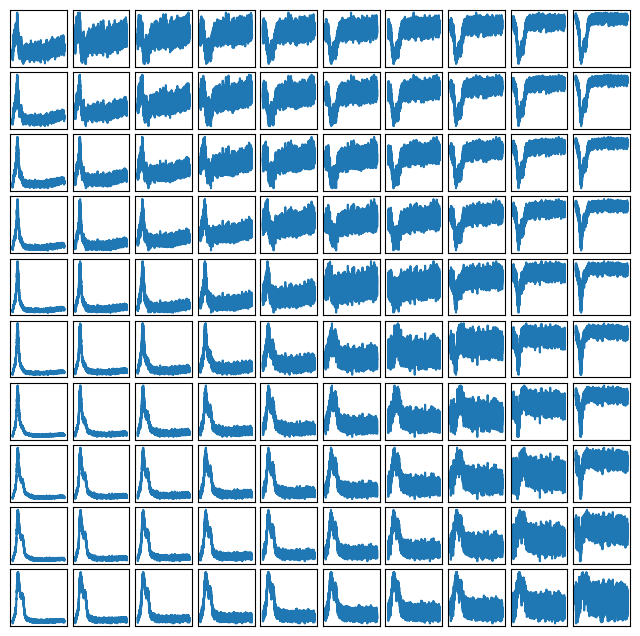

In [ ]:
vae.manifold2d(d=10); #ylim=[0.25, 0.33]

Plot the latent values for each image pixel:

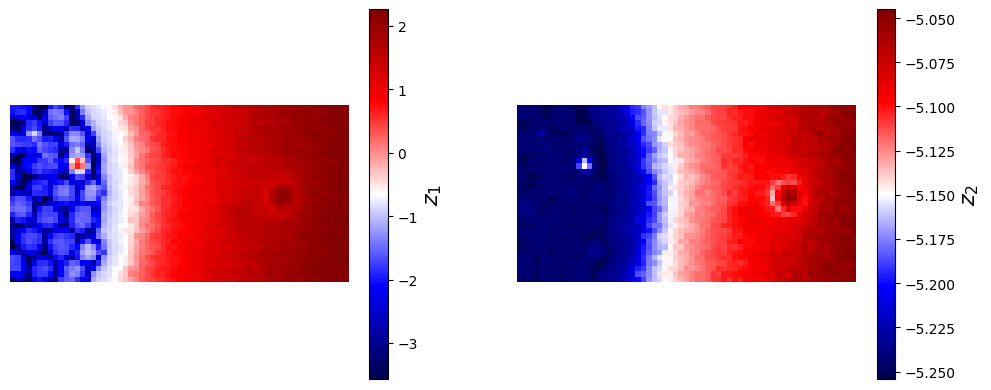

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='seismic')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=16)
im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='seismic')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$z_2$", fontsize=16)

### 3D latent space

In [ ]:
train_loader3 = pv.utils.init_dataloader(train_data, batch_size=64)

In [ ]:
in_dim = (l_signal,)

# Initialize vanilla VAE
vae3 = pv.models.iVAE(in_dim, latent_dim=3, invariances=None, sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize SVI trainer
trainer3 = pv.trainers.SVItrainer(vae3)

# Train for n epochs:
for e in range(50):
    trainer3.step(train_loader3, scale_factor=1)
    trainer3.print_statistics()

Epoch: 1 Training loss: 836671.1868
Epoch: 2 Training loss: 61235.1844
Epoch: 3 Training loss: 35786.8402
Epoch: 4 Training loss: 34463.8845
Epoch: 5 Training loss: 34513.2780
Epoch: 6 Training loss: 34368.0754
Epoch: 7 Training loss: 34495.5982
Epoch: 8 Training loss: 34404.6878
Epoch: 9 Training loss: 34170.1135
Epoch: 10 Training loss: 29752.9842
Epoch: 11 Training loss: 7640.6721
Epoch: 12 Training loss: -1307.1717
Epoch: 13 Training loss: -3504.6150
Epoch: 14 Training loss: -4396.5427
Epoch: 15 Training loss: -4559.5485
Epoch: 16 Training loss: -4778.3121
Epoch: 17 Training loss: -4840.4343
Epoch: 18 Training loss: -4902.9613
Epoch: 19 Training loss: -5135.6168
Epoch: 20 Training loss: -5248.2197
Epoch: 21 Training loss: -5308.7762
Epoch: 22 Training loss: -5432.9904
Epoch: 23 Training loss: -5533.2643
Epoch: 24 Training loss: -5591.6127
Epoch: 25 Training loss: -5620.4381
Epoch: 26 Training loss: -5790.7097
Epoch: 27 Training loss: -5661.2513
Epoch: 28 Training loss: -5880.8556
E

Text(0, 0.5, '$z_3$')

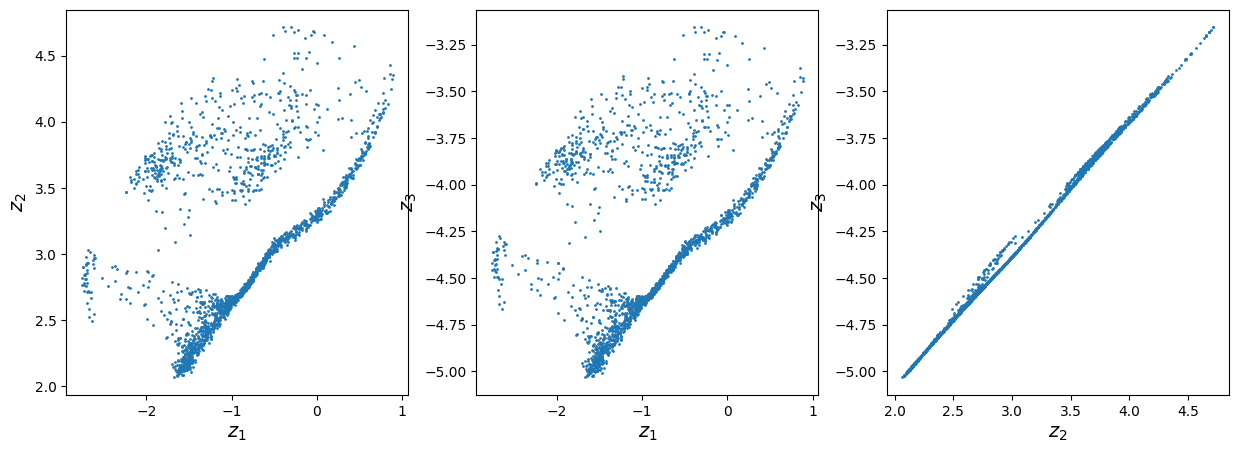

In [ ]:
z_mean, z_sd = vae3.encode(train_data)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.scatter(z_mean[:, 0], z_mean[:, 1], s=1)
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
ax2.scatter(z_mean[:, 0], z_mean[:, 2], s=1)
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_3$", fontsize=14)
ax3.scatter(z_mean[:, 1], z_mean[:, 2], s=1)
ax3.set_xlabel("$z_2$", fontsize=14)
ax3.set_ylabel("$z_3$", fontsize=14)

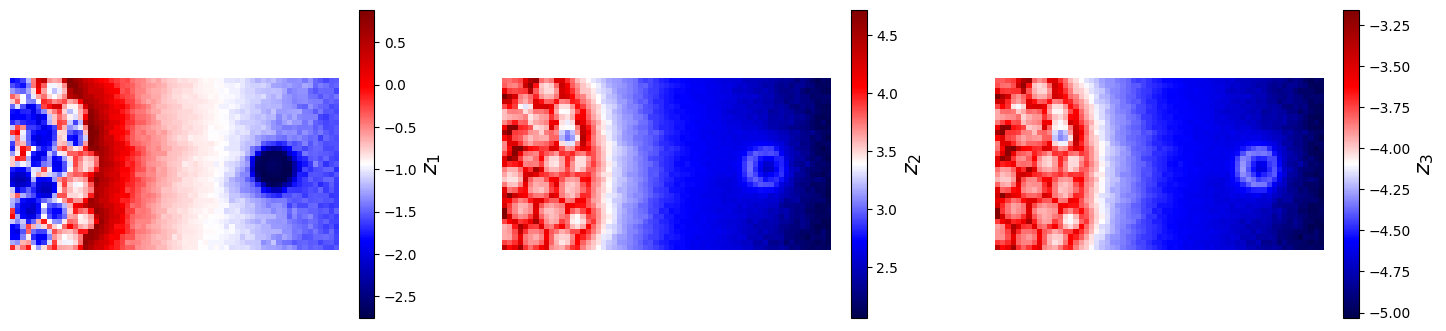

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='seismic')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=16)
im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='seismic')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$z_2$", fontsize=16)
im3 = ax3.imshow(z_mean[:, 2].reshape(s1,s2), cmap='seismic')
ax3.axis(False)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.8)
cbar3.set_label("$z_3$", fontsize=16)

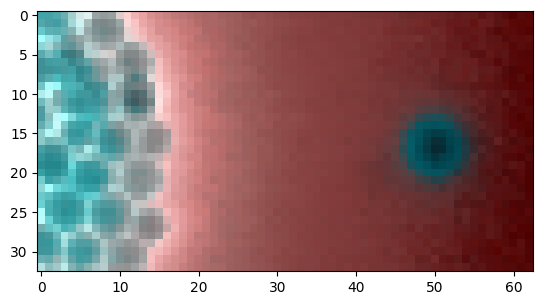

In [ ]:
# Will look better if normalize each component separately
normalize_func = lambda x: (x - x.min(dim=0)[0]) / (x.max(dim=0)[0] - x.min(dim=0)[0])
plt.imshow(normalize_func(z_mean[:]).reshape(s1,s2,3)[:,:,:3])

# jVAE analysis

As a reminder - jVAE tries to separate the data into classes, and disentangle representation in similar manner within each class. Comparatively, in cVAE we provide all the classes (eithe rdiscrete, or as continuous conditioning vector), and in ss-VAE we provide few examples of classes.

In [ ]:
# Re-initialize train loader
train_loader_j = pv.utils.init_dataloader(train_data, batch_size=64)

Get training data and create a dataloader object:

Epoch: 1 Training loss: 848974.8606
Epoch: 2 Training loss: 60937.3018
Epoch: 3 Training loss: 36714.2468
Epoch: 4 Training loss: 35387.1691
Epoch: 5 Training loss: 35334.9888
Epoch: 6 Training loss: 35118.7544
Epoch: 7 Training loss: 35208.2166
Epoch: 8 Training loss: 35100.7560
Epoch: 9 Training loss: 35043.3769
Epoch: 10 Training loss: 35354.2748


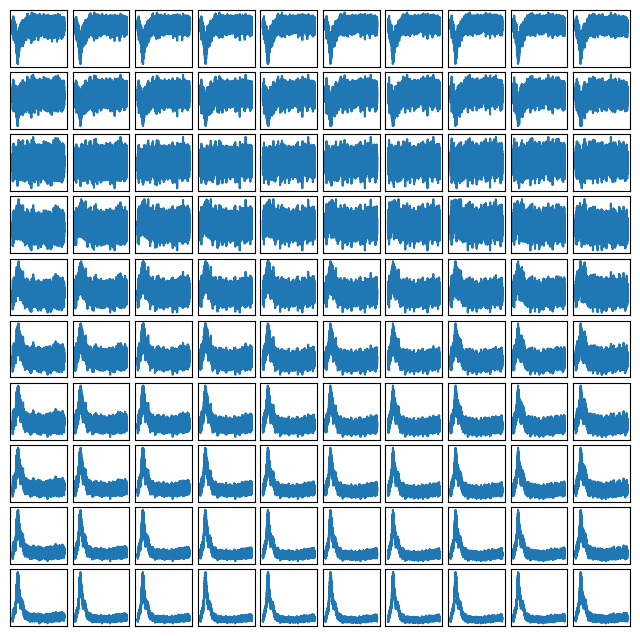

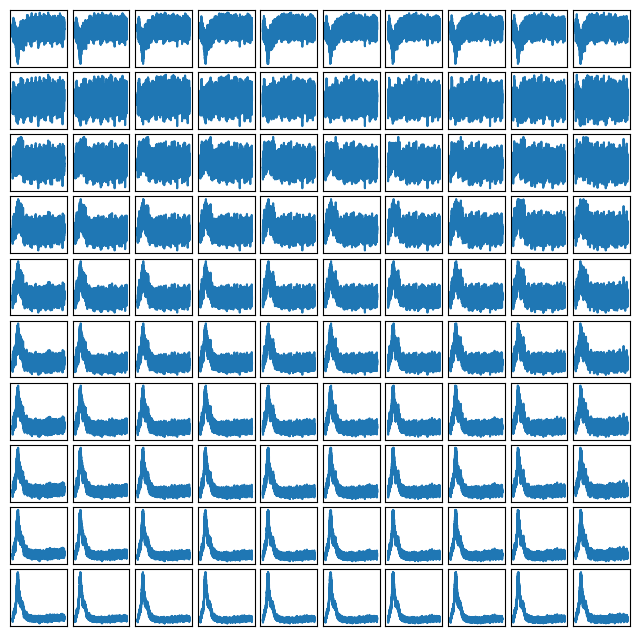

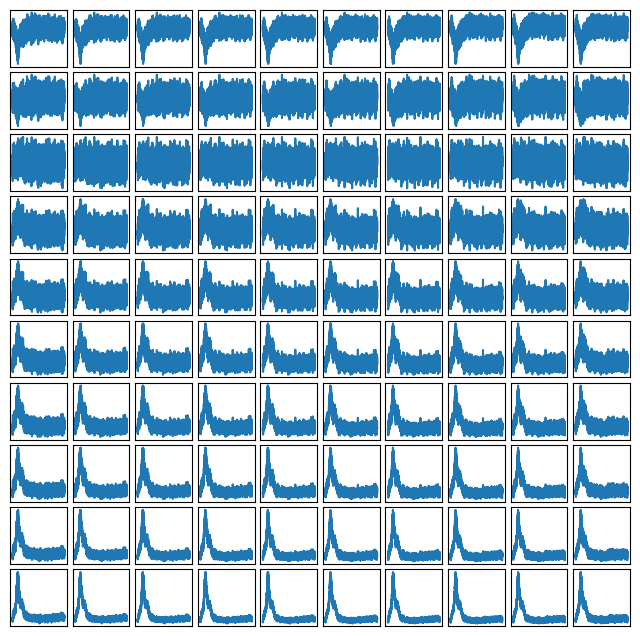

Epoch: 11 Training loss: 35338.6744
Epoch: 12 Training loss: 35161.8805
Epoch: 13 Training loss: 35179.9242
Epoch: 14 Training loss: 34999.8457
Epoch: 15 Training loss: 32363.1338
Epoch: 16 Training loss: 12061.2864
Epoch: 17 Training loss: -1669.9449
Epoch: 18 Training loss: -3661.2103
Epoch: 19 Training loss: -4252.8413
Epoch: 20 Training loss: -4541.6553


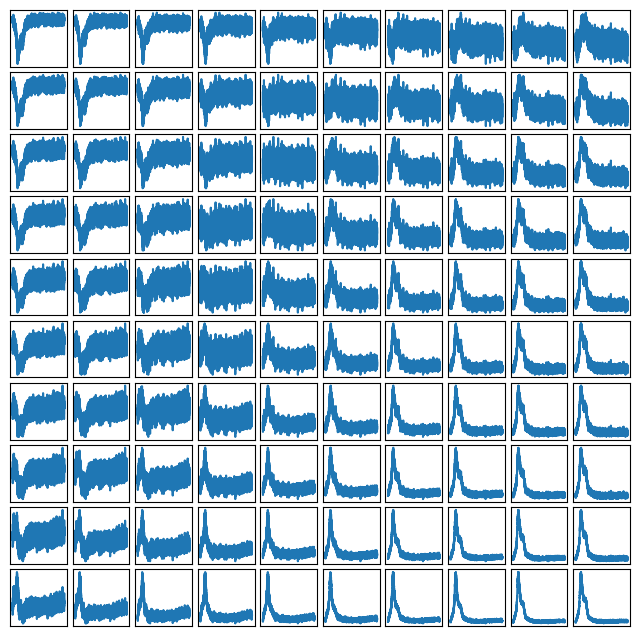

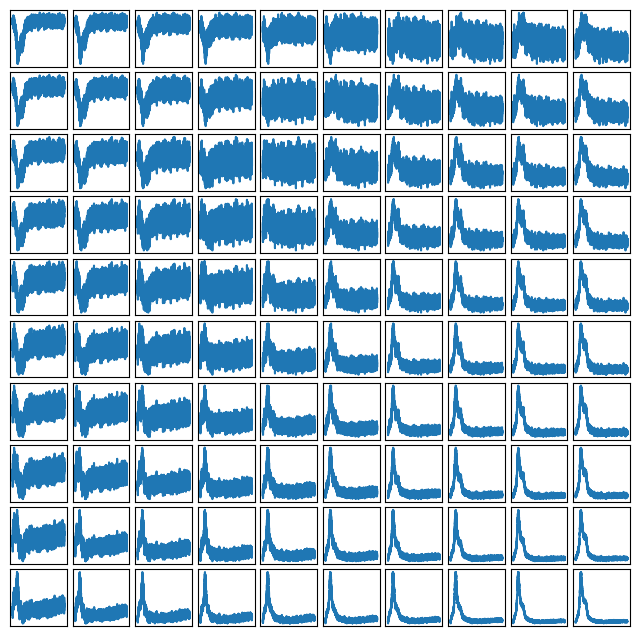

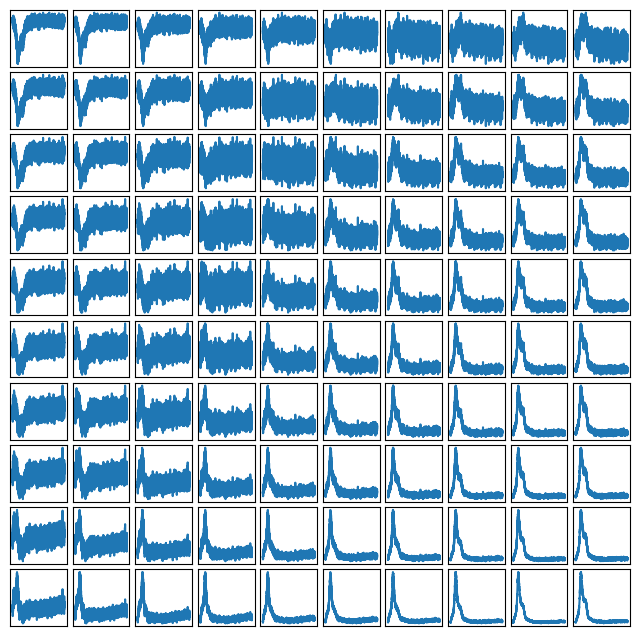

Epoch: 21 Training loss: -4710.6734
Epoch: 22 Training loss: -4795.4560
Epoch: 23 Training loss: -5003.1540
Epoch: 24 Training loss: -5134.0565
Epoch: 25 Training loss: -5248.2812
Epoch: 26 Training loss: -5314.7500
Epoch: 27 Training loss: -5473.1524
Epoch: 28 Training loss: -5539.6086
Epoch: 29 Training loss: -5537.0728
Epoch: 30 Training loss: -5694.5310


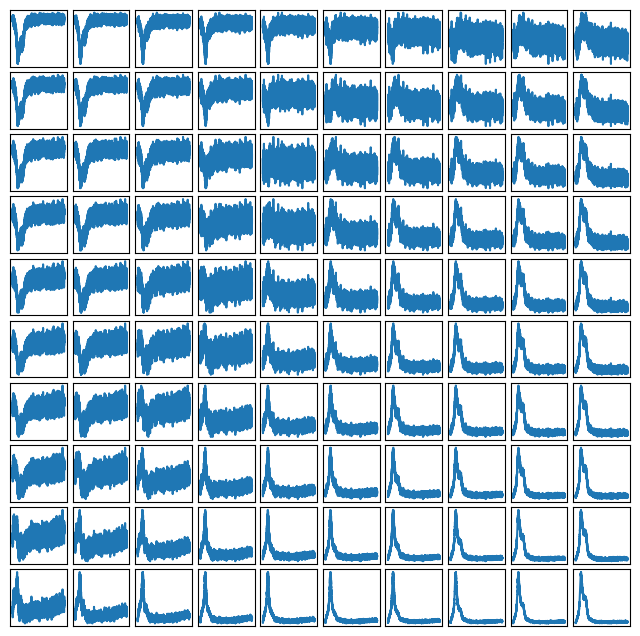

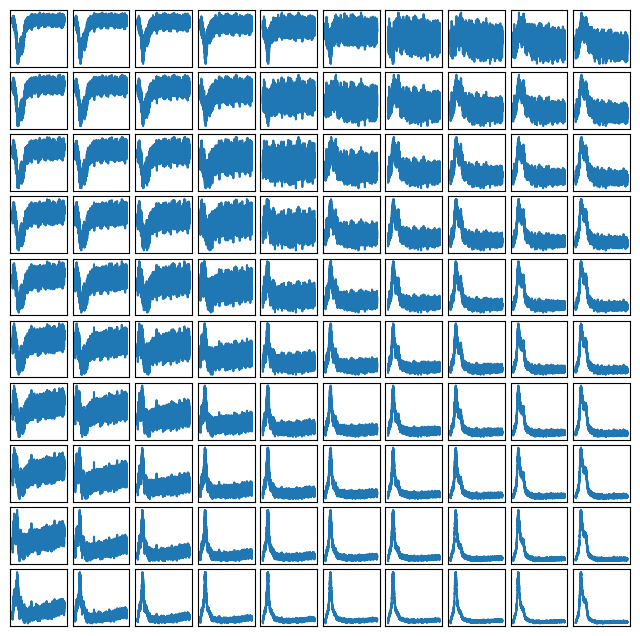

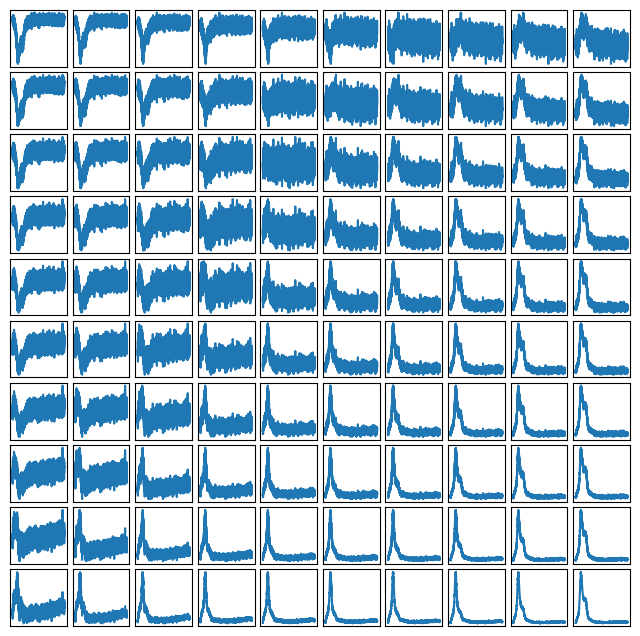

Epoch: 31 Training loss: -5733.8536
Epoch: 32 Training loss: -5769.2664
Epoch: 33 Training loss: -5884.9355
Epoch: 34 Training loss: -5885.2191
Epoch: 35 Training loss: -5858.2114
Epoch: 36 Training loss: -6021.6260
Epoch: 37 Training loss: -6056.9684
Epoch: 38 Training loss: -6029.1401
Epoch: 39 Training loss: -6064.8650
Epoch: 40 Training loss: -6174.3834


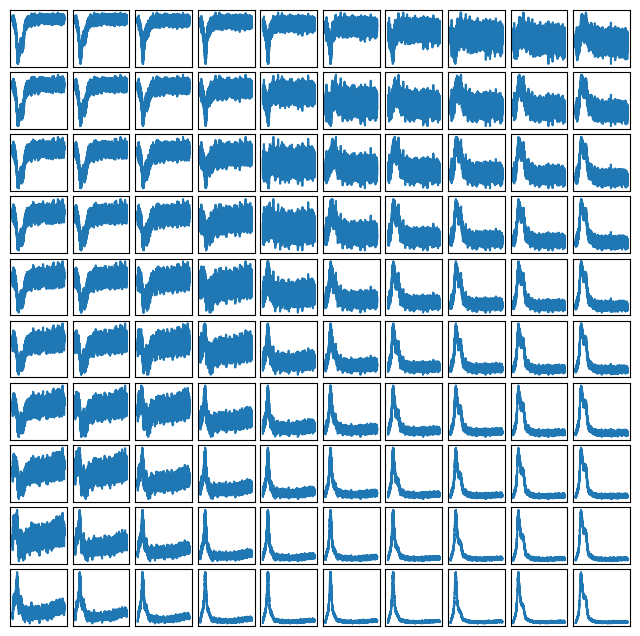

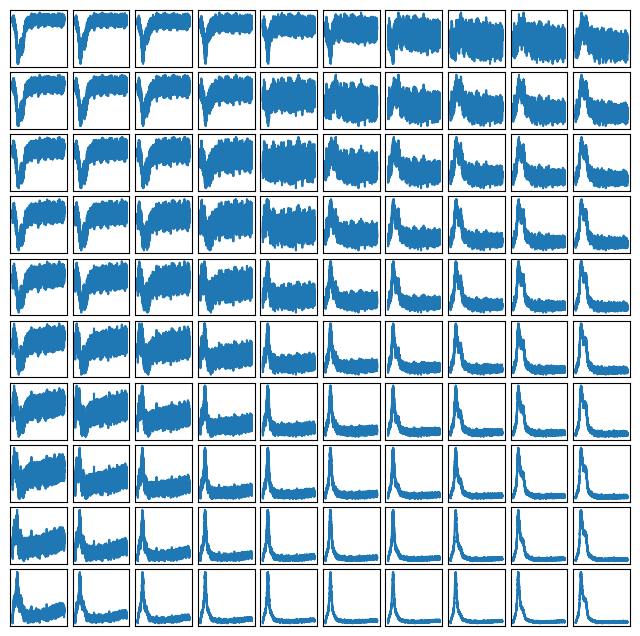

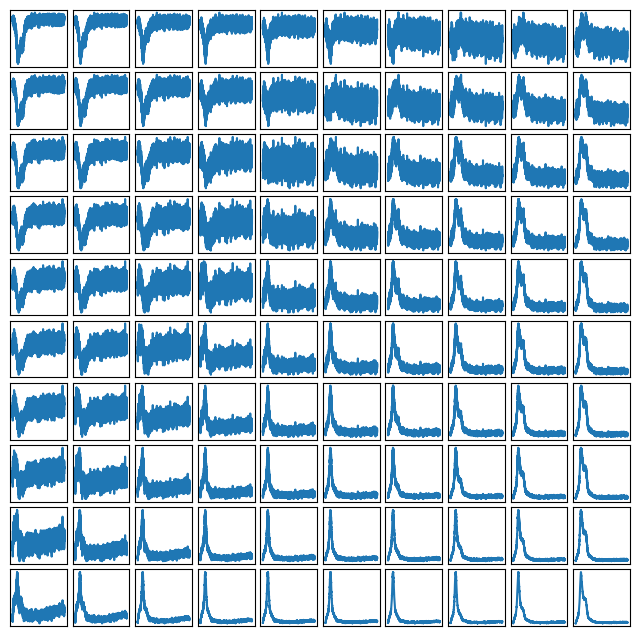

Epoch: 41 Training loss: -6199.6532
Epoch: 42 Training loss: -6024.6961
Epoch: 43 Training loss: -6176.2597
Epoch: 44 Training loss: -6275.0159
Epoch: 45 Training loss: -6320.1854
Epoch: 46 Training loss: -6541.2925
Epoch: 47 Training loss: -6694.5770
Epoch: 48 Training loss: -7106.0190
Epoch: 49 Training loss: -7748.0280
Epoch: 50 Training loss: -8409.3436


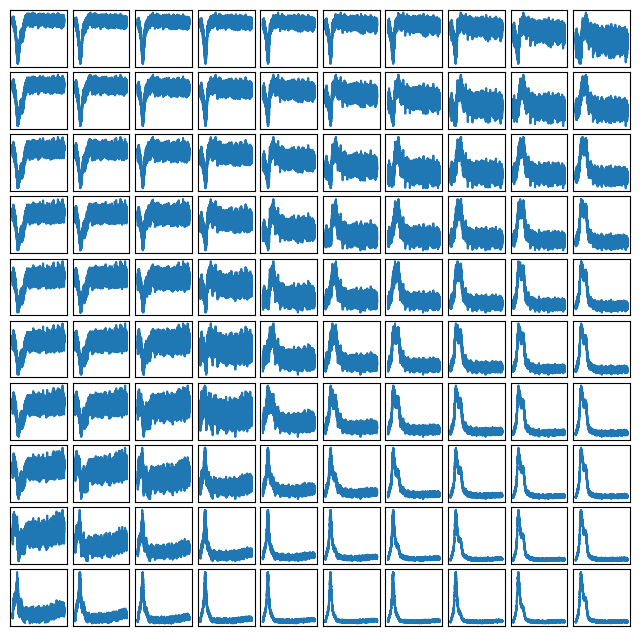

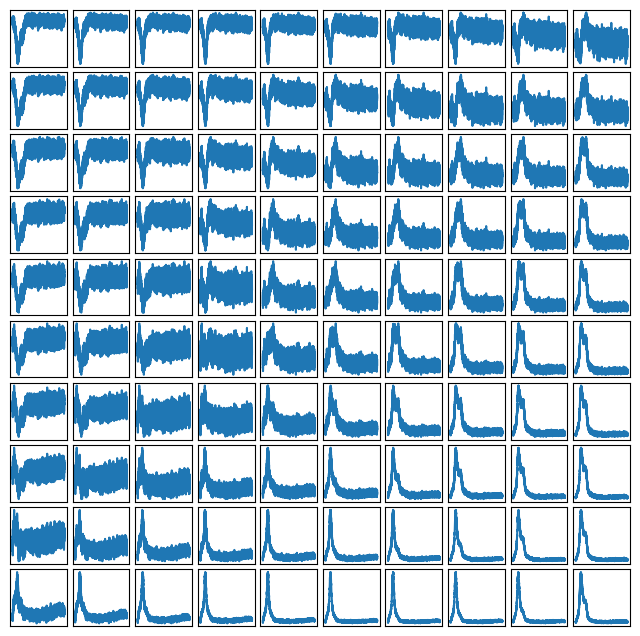

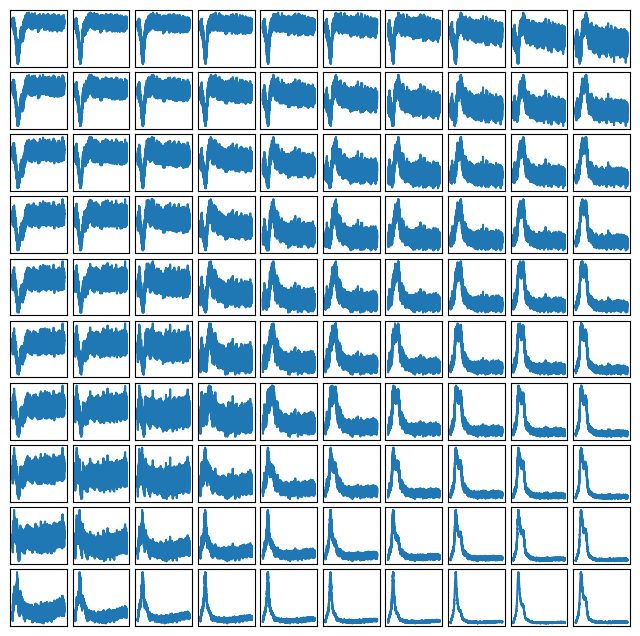

Epoch: 51 Training loss: -8769.0706
Epoch: 52 Training loss: -9122.3254
Epoch: 53 Training loss: -9458.1929
Epoch: 54 Training loss: -9618.4983
Epoch: 55 Training loss: -9778.4148
Epoch: 56 Training loss: -9851.1882
Epoch: 57 Training loss: -10005.8348
Epoch: 58 Training loss: -10046.2747
Epoch: 59 Training loss: -10103.7841
Epoch: 60 Training loss: -10141.2185


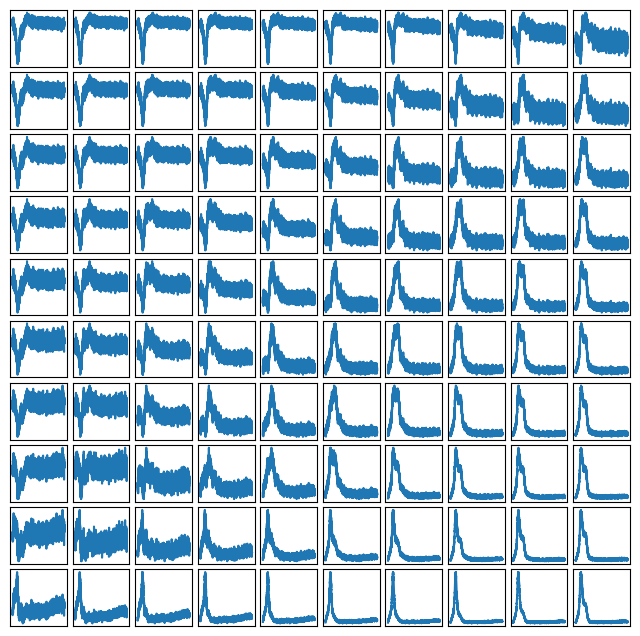

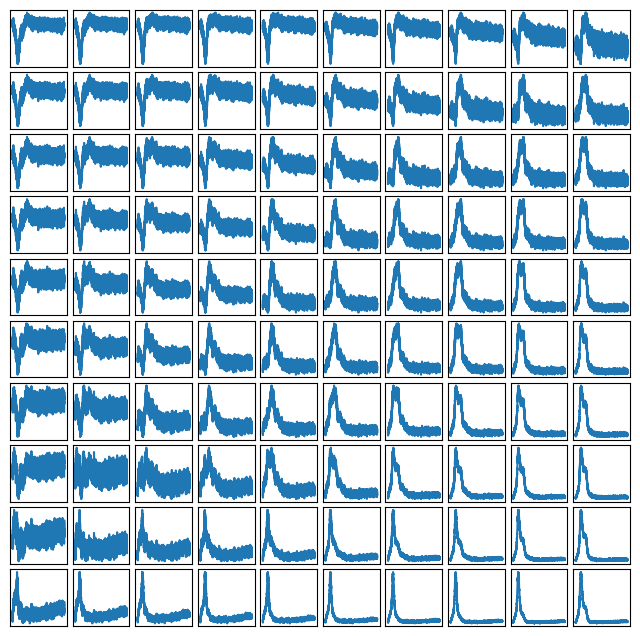

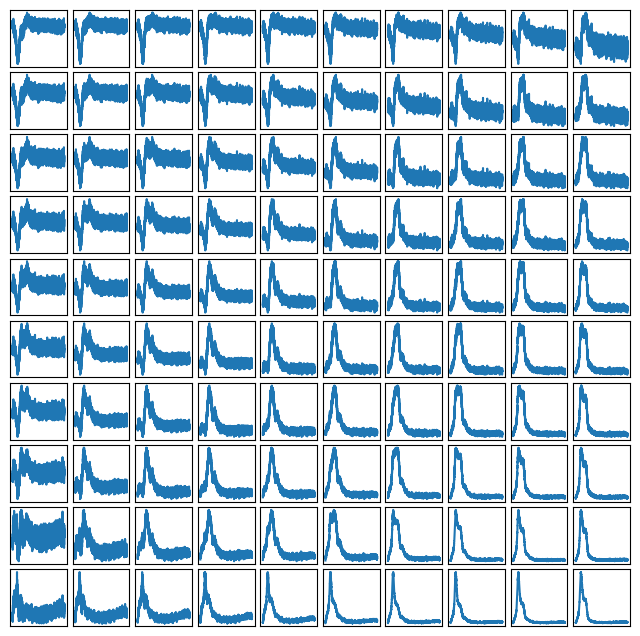

Epoch: 61 Training loss: -10006.6001
Epoch: 62 Training loss: -9988.3353
Epoch: 63 Training loss: -10213.1095
Epoch: 64 Training loss: -10117.3417
Epoch: 65 Training loss: -10245.6276
Epoch: 66 Training loss: -10285.5391
Epoch: 67 Training loss: -10280.4540
Epoch: 68 Training loss: -10297.2668
Epoch: 69 Training loss: -10217.3302
Epoch: 70 Training loss: -10253.1125


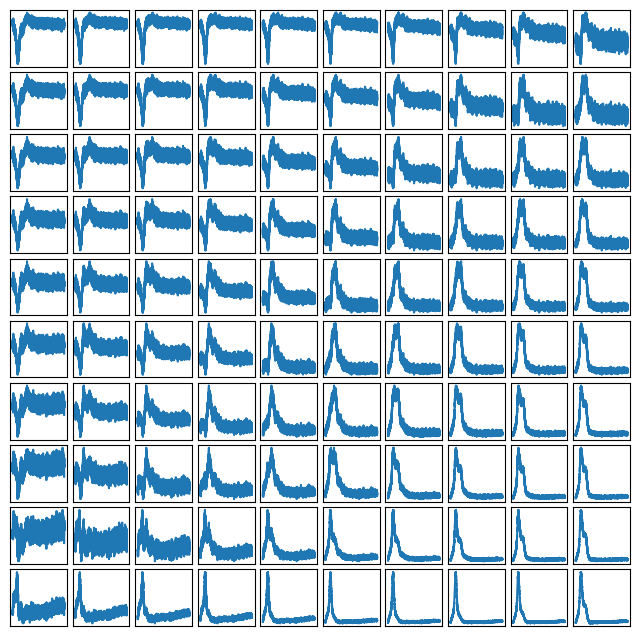

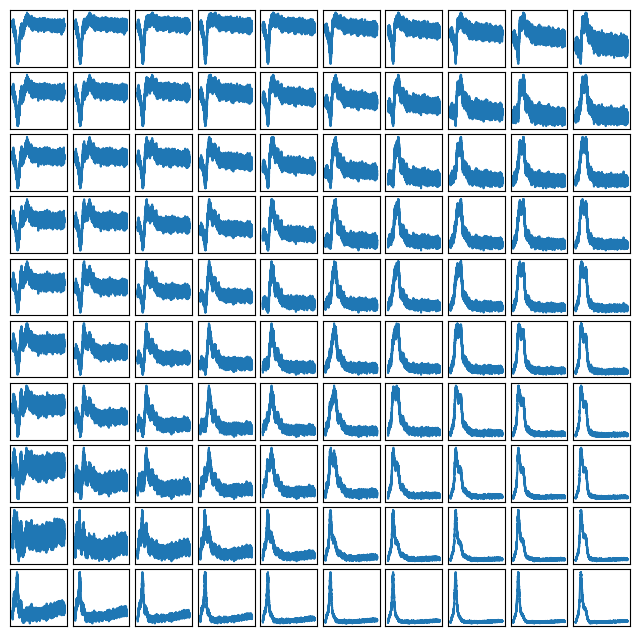

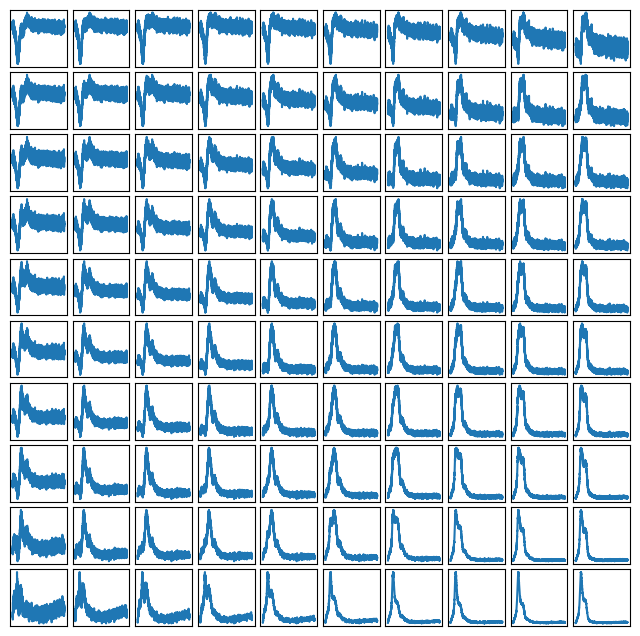

Epoch: 71 Training loss: -10316.8175
Epoch: 72 Training loss: -10334.6569
Epoch: 73 Training loss: -10314.2673
Epoch: 74 Training loss: -10334.3977
Epoch: 75 Training loss: -10359.6932
Epoch: 76 Training loss: -10346.0957
Epoch: 77 Training loss: -10299.4036
Epoch: 78 Training loss: -10329.2074
Epoch: 79 Training loss: -10385.0498
Epoch: 80 Training loss: -10352.2025


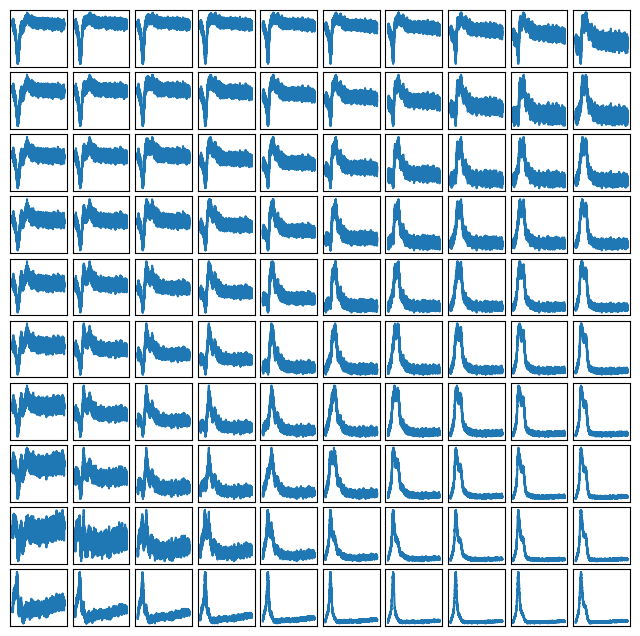

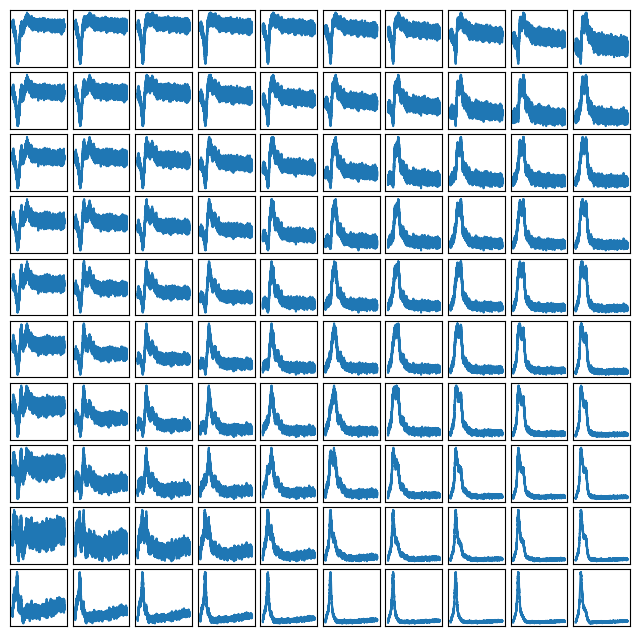

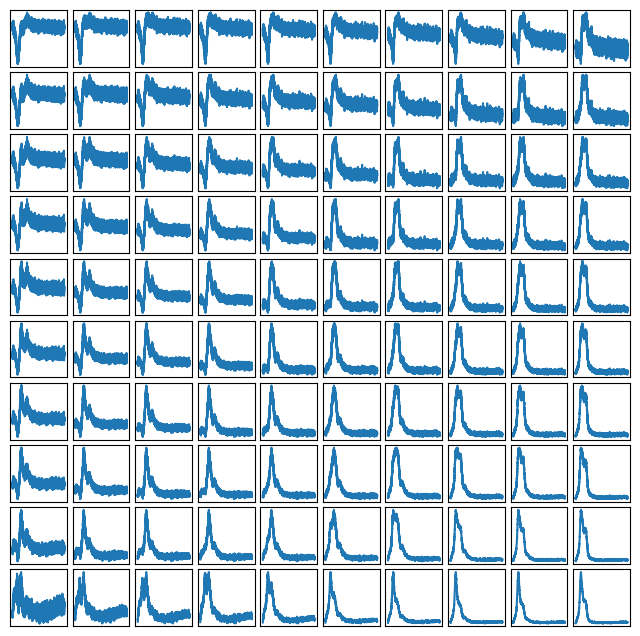

Epoch: 81 Training loss: -10331.1632
Epoch: 82 Training loss: -10337.2541
Epoch: 83 Training loss: -10319.7437
Epoch: 84 Training loss: -10338.8001
Epoch: 85 Training loss: -10343.1054
Epoch: 86 Training loss: -10380.4988
Epoch: 87 Training loss: -10393.2858
Epoch: 88 Training loss: -10387.9685
Epoch: 89 Training loss: -10365.0995
Epoch: 90 Training loss: -10374.6669


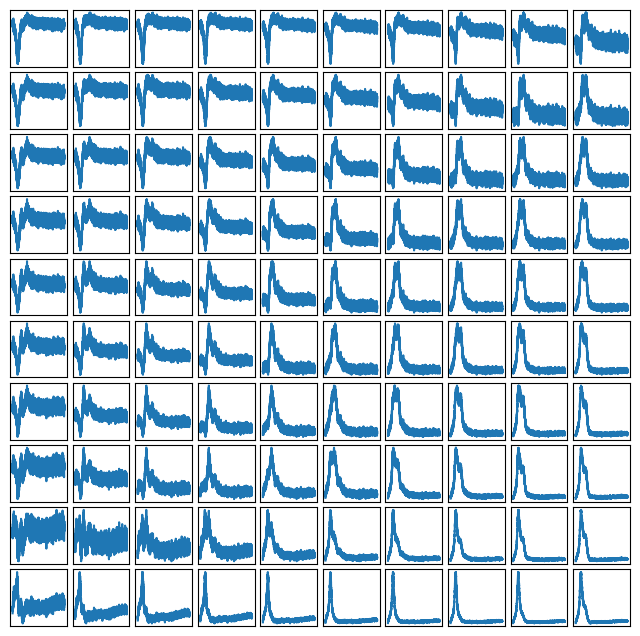

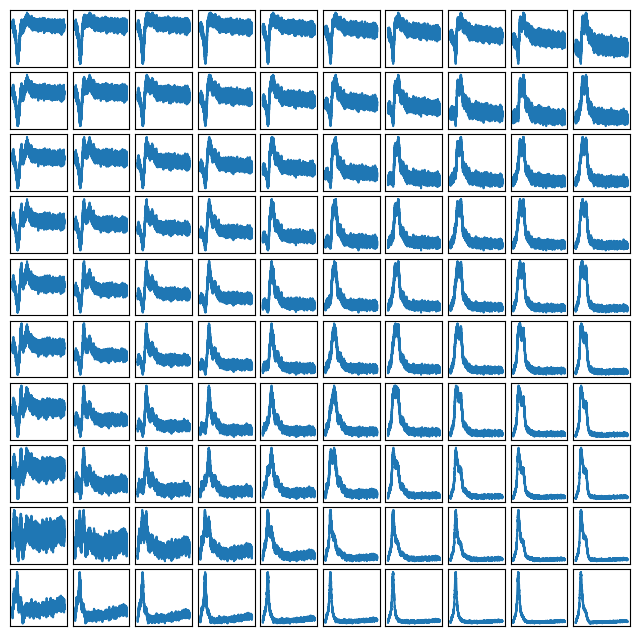

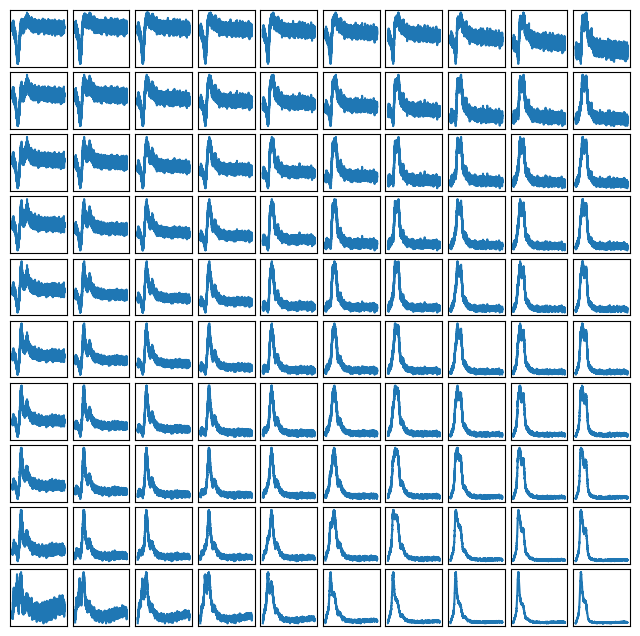

Epoch: 91 Training loss: -10432.9637
Epoch: 92 Training loss: -10420.5980
Epoch: 93 Training loss: -10422.1396
Epoch: 94 Training loss: -10403.8599
Epoch: 95 Training loss: -10410.0899
Epoch: 96 Training loss: -10350.8326
Epoch: 97 Training loss: -10383.2305
Epoch: 98 Training loss: -10346.9304
Epoch: 99 Training loss: -10338.5899
Epoch: 100 Training loss: -10390.2147


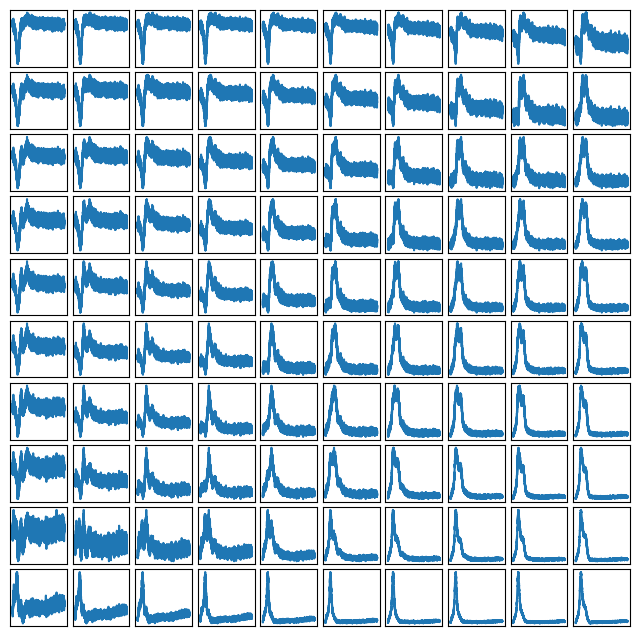

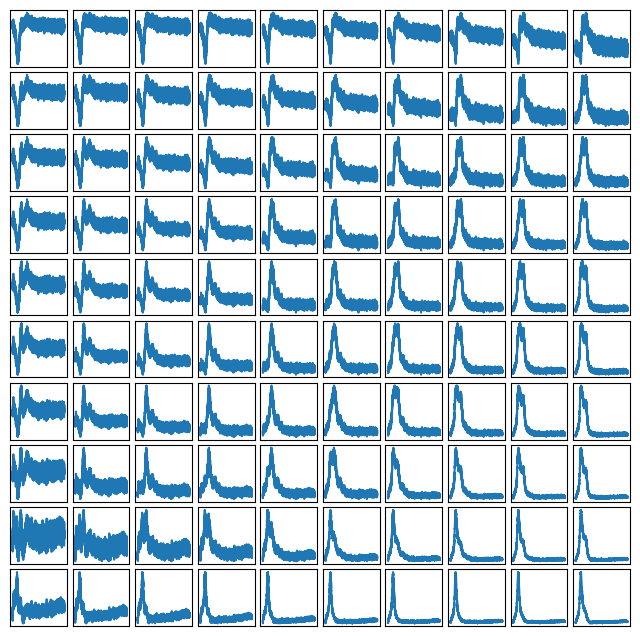

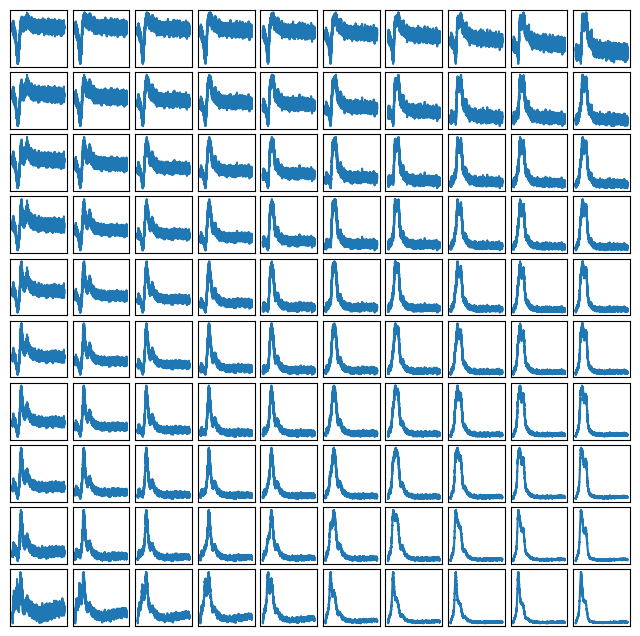

In [ ]:
# Input data dimensions
data_dim = (l_signal,)

# Initialize joint VAE model (note that we have to enter our "guess" about the number of discrete classes in the system)
jvae = pv.models.jiVAE(data_dim, latent_dim=2, discrete_dim=3, invariances=None,
                       sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize trainer (note that we are going to use parallel enumeration instead of Gumbel-Softmax approx)
trainer_j = pv.trainers.SVItrainer(jvae, lr=1e-3, enumerate_parallel=True)

# Train the model
# Use time-dependent KL scale term for continuous latent variables. The idea is to put a large pressure on the continuous latent channel
# to allow a good initialization of the discrete "centroids" and then gradually release the pressure to allow for finding the continuous traits in each class

kl_cont = torch.cat([40 * torch.ones(10,), torch.linspace(40, 2, 40)])

for e in range(100):
    sc = kl_cont[e] if e < len(kl_cont) else kl_cont[-1]
    trainer_j.step(train_loader_j, scale_factor=[sc, 1])
    trainer_j.print_statistics()

    if (e + 1) % 10 == 0:
        for i in range(3):
            jvae.manifold2d(d=10, disc_idx=i); #ylim=[0.25, 0.33]

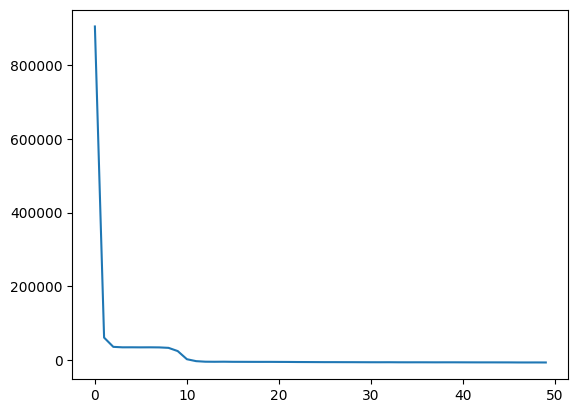

In [ ]:
plt.plot(trainer.loss_history["training_loss"])

Visualize the learned latent manifold:

(note that classes are learned in an unsupervised manner and their order depends on the (pseudo-)random initialization of model parameters)

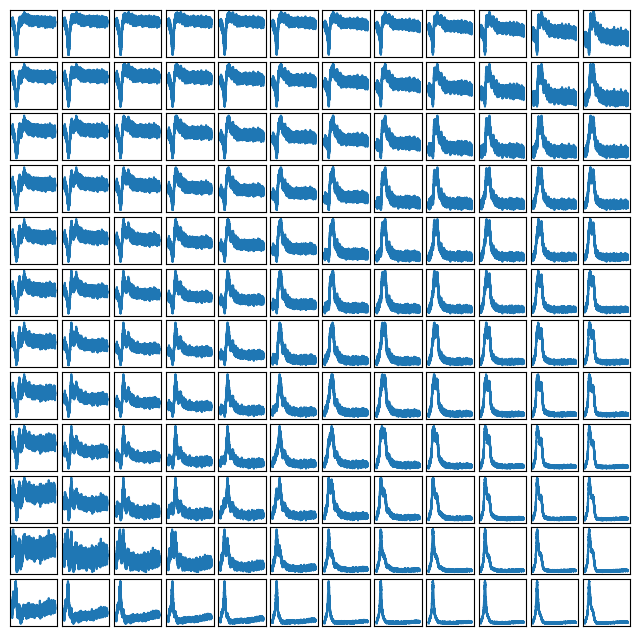

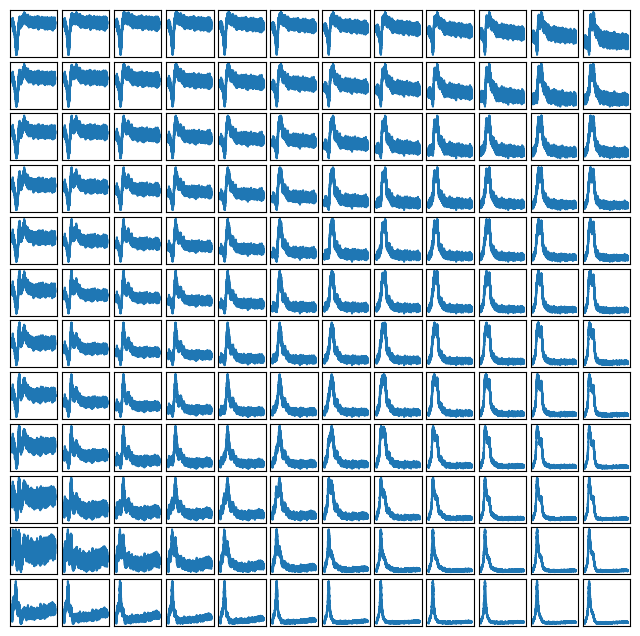

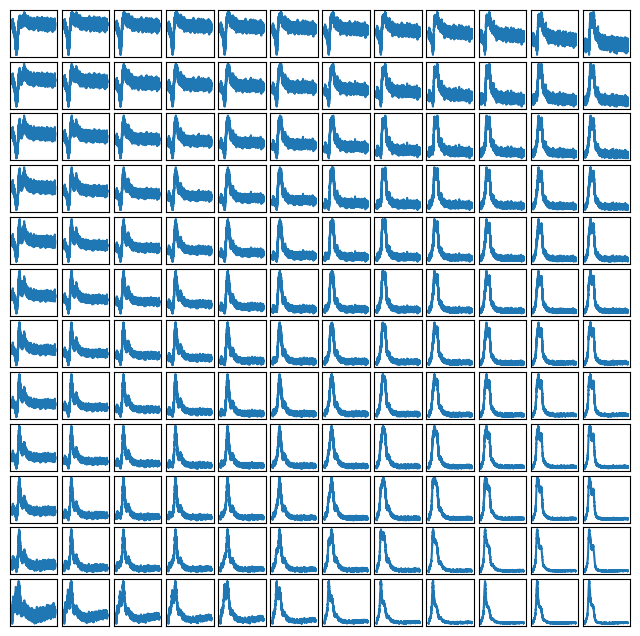

In [ ]:
for i in range(3):
    jvae.manifold2d(d=12, disc_idx=i); #ylim=[.25, .33]

In [ ]:
z_mean, _, y_pred = jvae.encode(train_data)

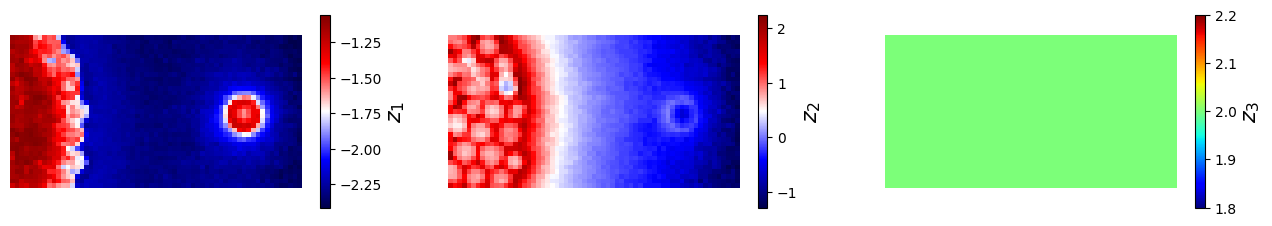

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5), dpi=100)

im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='seismic')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.5)
cbar1.set_label("$z_1$", fontsize=16)

im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='seismic')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.5)
cbar2.set_label("$z_2$", fontsize=16)

im3 = ax3.imshow(y_pred.reshape(s1,s2), cmap='jet', interpolation='gaussian')
ax3.axis(False)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.5)
cbar3.set_label("$z_3$", fontsize=16)

plt.show()

Plot continuous latent variables for each identified class:

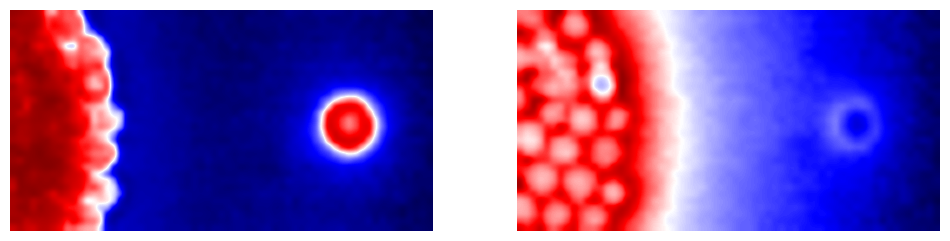

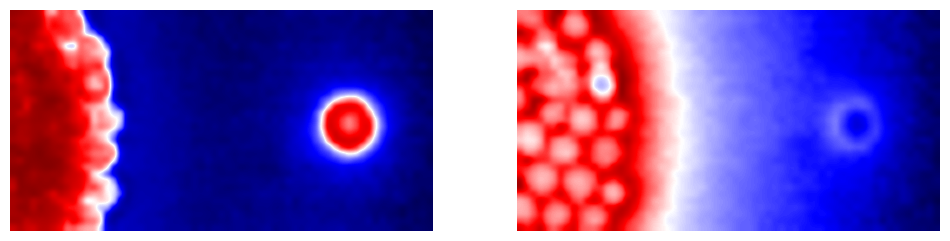

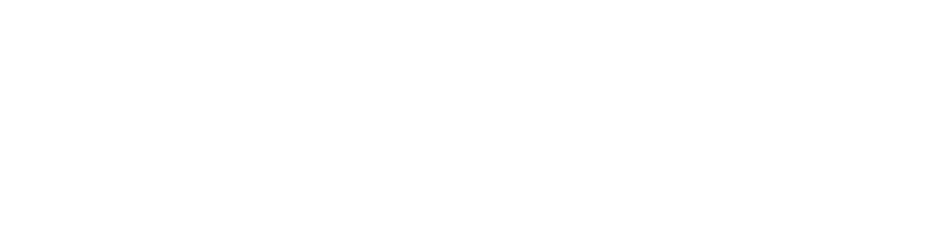

In [ ]:
for cl in range(3):
    z1, z2 = dc(z_mean.reshape(s1,s2, 2)).split(1, dim=-1)
    y = dc(y_pred.reshape(s1,s2))
    z1[y == cl] = np.nan
    z2[y == cl] = np.nan
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(z1.squeeze(), cmap='seismic', interpolation='gaussian')
    ax1.axis(False)
    ax2.imshow(z2.squeeze(), cmap='seismic', interpolation='gaussian')
    ax2.axis(False)
    plt.show()

Basically, in this case jVAE thinks there is only one class. Based on data above, I think that it decide dso because it locked onto primary peak intensity as a main parameter.

# Continuous conditional VAE

Here, we can condition our VAE on some external parameter. This is very powerful option of VAEs that have been explored for real data only weakly. Overall, we speculate that if some factor of variability is known, then conditioning on it will remove it from data. For the time being,  we illustrate conditioning on zero order PCA component.

You can read about more detailed studies: https://arxiv.org/abs/2203.03122

Do experiment on your own data (note that conditional vector can be discrete)!

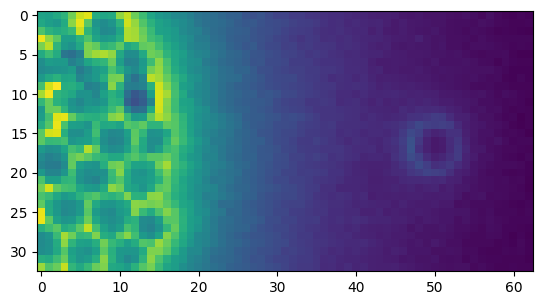

In [ ]:
plt.imshow(X_vec_t[:, 0].reshape(d1, d2))
mu = X_vec_t[:, 0]

In [ ]:
print(train_data.shape, mu.shape)

torch.Size([2079, 4322]) (2079,)


In [ ]:
# Initialize train loader
mu = torch.tensor(mu).float().unsqueeze(1) #.unsqueeze(1)
#train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), mu, batch_size=64)
train_loader_cc = pv.utils.init_dataloader(train_data, mu, batch_size=64)

In [ ]:
mu.shape

torch.Size([2079, 1])

In [ ]:
train_loader

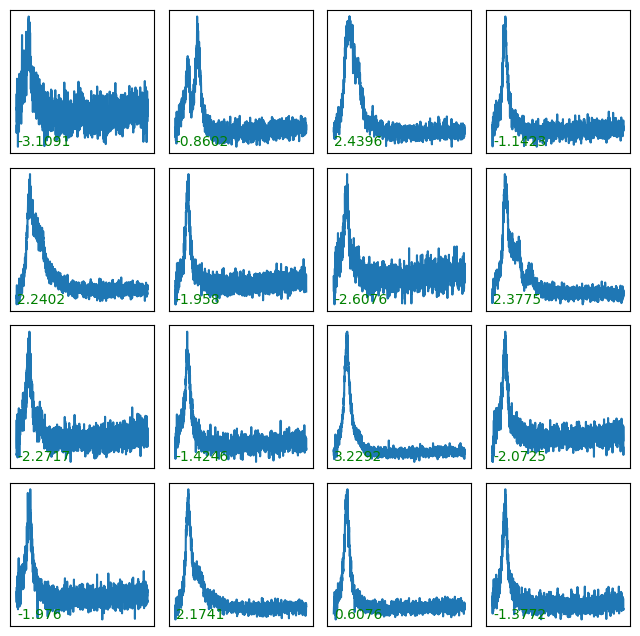

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y, m) in zip(axes.flat, train_loader_cc):
    ax.plot(x, y[0,:])
    # ax.set_ylim(0.25, .35)
    ax.text(0.05, 0.05, str(np.around(m[0].item(), decimals=4)),
            transform=ax.transAxes, color='green')

Train VAE model where our prior is conditioned on a continuous vector $c$ as $p(z|c)$. Here we pass the information about shifts as our $c$ vector.

In [ ]:
in_dim = (l_signal,)

# Initialize VAE (we specify c_dim=1 to add extra-dimension corresponding to c-vector to the decoder)
vae_cc = pv.models.iVAE(in_dim, latent_dim=2, c_dim=1, invariances=None,
                     sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize SVI trainer
trainer_cc = pv.trainers.SVItrainer(vae_cc)

# Train for n epochs:
for e in range(50):
    trainer_cc.step(train_loader_cc)
    trainer_cc.print_statistics()

Epoch: 1 Training loss: 912836.0223
Epoch: 2 Training loss: 46902.9582
Epoch: 3 Training loss: 3981.5702
Epoch: 4 Training loss: -2291.3087
Epoch: 5 Training loss: -3495.8851
Epoch: 6 Training loss: -3982.5024
Epoch: 7 Training loss: -4302.7525
Epoch: 8 Training loss: -4507.0275
Epoch: 9 Training loss: -4683.1423
Epoch: 10 Training loss: -4783.8571
Epoch: 11 Training loss: -4902.1756
Epoch: 12 Training loss: -4971.5012
Epoch: 13 Training loss: -5047.9753
Epoch: 14 Training loss: -5107.6079
Epoch: 15 Training loss: -5110.3618
Epoch: 16 Training loss: -5235.6261
Epoch: 17 Training loss: -5208.5909
Epoch: 18 Training loss: -5227.2464
Epoch: 19 Training loss: -5366.8248
Epoch: 20 Training loss: -5400.2802
Epoch: 21 Training loss: -5423.2970
Epoch: 22 Training loss: -5485.6978
Epoch: 23 Training loss: -5547.3689
Epoch: 24 Training loss: -5524.0537
Epoch: 25 Training loss: -5604.0706
Epoch: 26 Training loss: -5645.7115
Epoch: 27 Training loss: -5589.4076
Epoch: 28 Training loss: -5584.8884
E

In [ ]:
train_data.unsqueeze(-1).shape

torch.Size([2079, 4322, 1])

Encode the training data into the latent space:

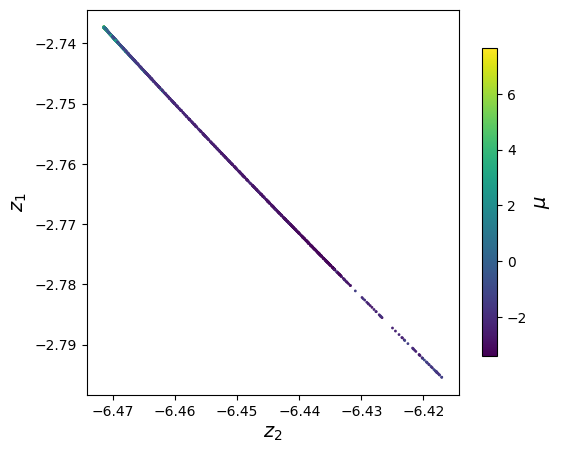

In [ ]:
z_mean, z_sd = vae_cc.encode(train_data, mu)

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)

Plot the learned latent manifolds conditioned on one of the PCA components:

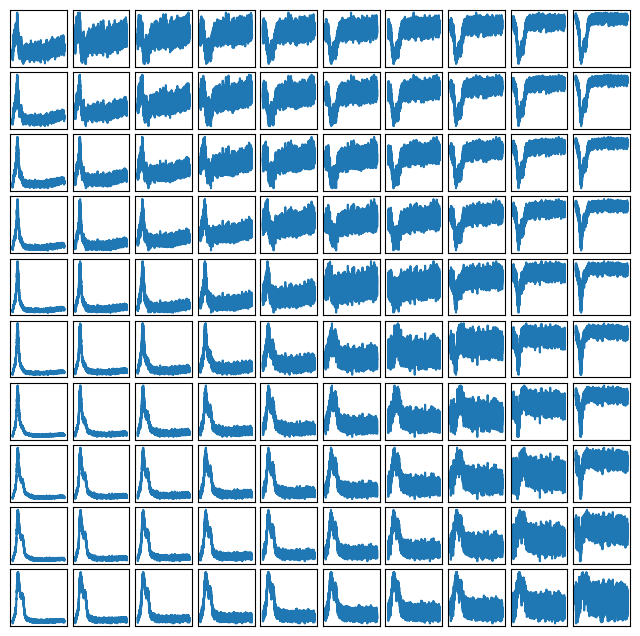

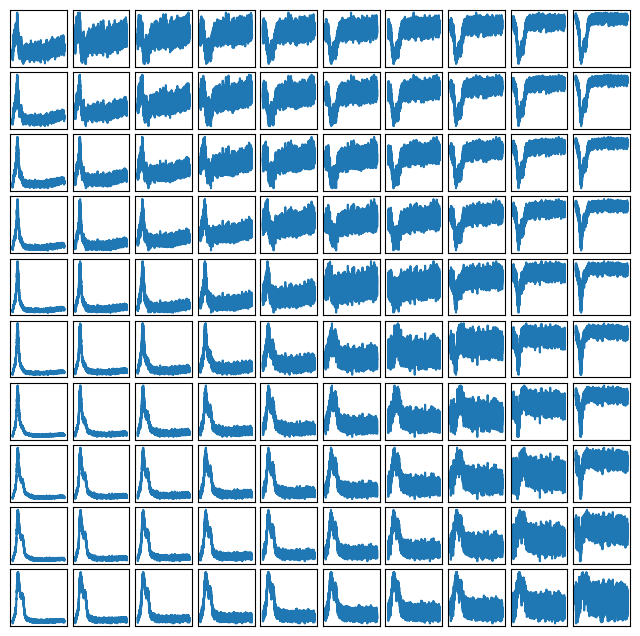

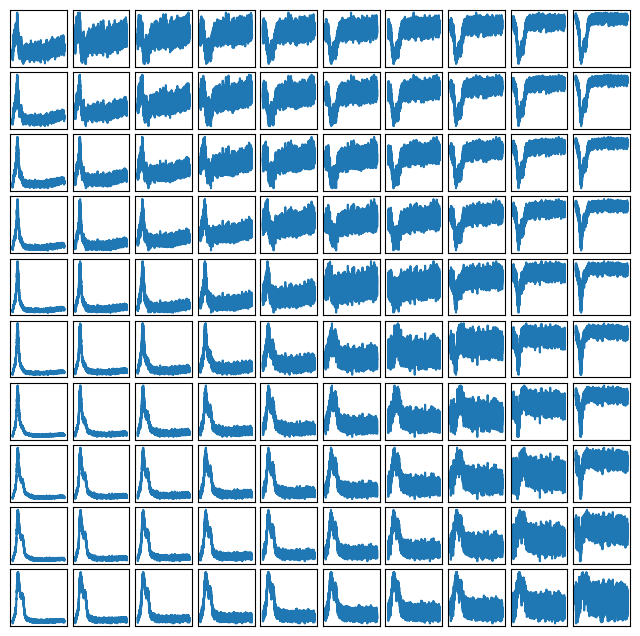

In [ ]:
y_all = [-2, 0, 2]

for y in y_all:
    y = torch.tensor(y).unsqueeze(0)
    vae.manifold2d(10, y)

Plot the latent variables in the data space:

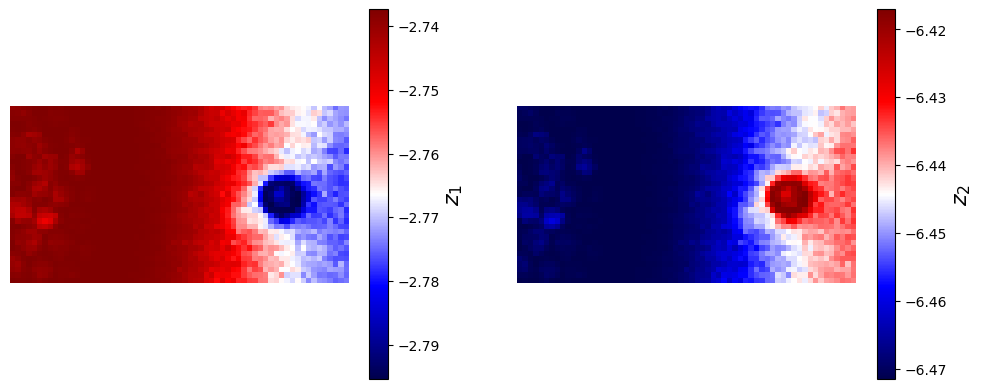

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='seismic')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=16)
im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='seismic')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$z_2$", fontsize=16)

Note that this conditioning has indeed produced very interesting effects. Our separation of different regions become much better - looks like we compensated for 0-order effect and now se efiner details of variability.

# ss-VAE

Semi-supervised VAE is the version of the VAE that can simultaneously disentangle the representations of the data and classify the data given (some)examples.  In some sense, it is much more high tech analog of the label propagation method reported in: https://arxiv.org/abs/2009.08501

- The choice of labels is paramount - can be based on topo features, expected localization of plasmons based on specific models, etc.

- Here, I use simplest (and not the best) method of selecting special regions based on peaks in PCA data sets.

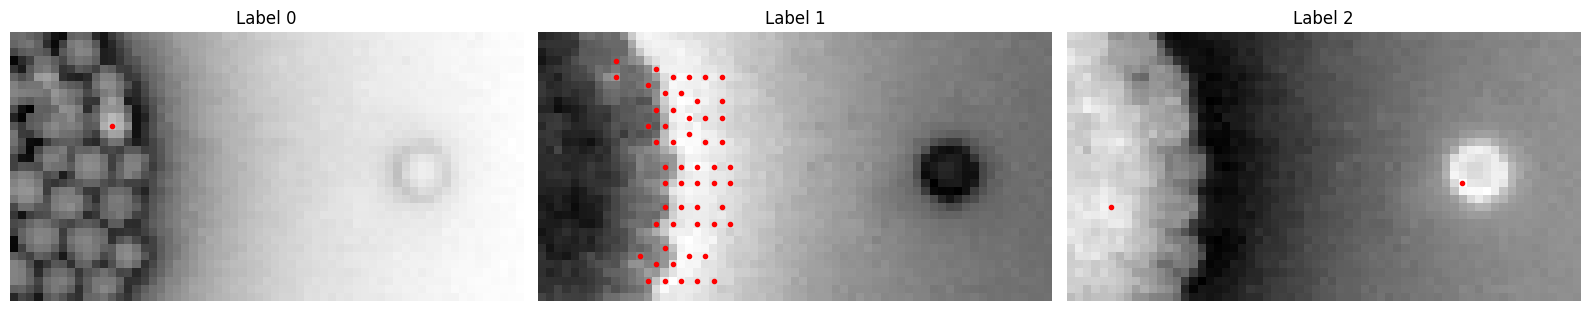

(1, 4322) (54, 4322) (2, 4322)


In [ ]:
# This code allows to create label array using simple maximu finding on PCA components
# Labels can be created in any other way, including manual selection

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

train_data = hdata
im0 = - X_vec_t[:, 0].reshape(d1, d2)
X_train = np.array(train_data)

image_max0 = ndi.maximum_filter(im0, size=2, mode='constant')
coordinates0 = peak_local_max(image_max0, min_distance=5, threshold_abs = 0.3, exclude_border = True)
label0 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates0])

im1 = - X_vec_t[:, 1].reshape(d1, d2)
image_max1 = ndi.maximum_filter(im1, size=10, mode='constant')
coordinates1 = peak_local_max(image_max1, min_distance=2, threshold_abs = 0.9, exclude_border = True)
label1 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates1])

im2 = X_vec_t[:, 1].reshape(d1, d2)
image_max2 = ndi.maximum_filter(im2, size=2, mode='constant')
coordinates2 = peak_local_max(image_max2, threshold_abs = 0.5, min_distance=5)
label2 = np.array([X_train.reshape(d1,d2,d3)[i,j,:] for i,j in coordinates2])

# display results
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

ax = axes.ravel()
ax[0].imshow(im0, cmap=plt.cm.gray)
ax[0].plot(coordinates0[:, 1], coordinates0[:, 0], 'r.')
ax[0].axis('off')
ax[0].set_title('Label 0')

ax[1].imshow(im1, cmap=plt.cm.gray)
ax[1].plot(coordinates1[:, 1], coordinates1[:, 0], 'r.')
ax[1].axis('off')
ax[1].set_title('Label 1')

ax[2].imshow(im2, cmap=plt.cm.gray)
ax[2].plot(coordinates2[:, 1], coordinates2[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Label 2')

fig.tight_layout()
plt.show()

print(label0.shape, label1.shape, label2.shape)

In [ ]:
# Here we create label arrays

imstack_train_s = np.concatenate((label0, label1, label2))

labels_train_s = np.concatenate((np.zeros(len(label0)),
                                 np.zeros(len(label1))+1,
                                 np.zeros(len(label2))+2))

print(imstack_train_s.shape, labels_train_s.shape)

(57, 4322) (57,)


In [ ]:
def plot_manifolds(model):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
X_sup = []
y_sup = []

X_unsup = torch.tensor(train_data.reshape(d1*d2,d3)).float()

for i, (image, label) in enumerate(zip(imstack_train_s, labels_train_s)):
    X_sup.append(image)
    y_sup.append(np.eye(3, dtype='uint8')[int(label)])

X_sup = np.array(X_sup)
y_sup = np.array(y_sup)

X_sup = torch.tensor(X_sup).float()
y_sup = torch.tensor(y_sup).float()

In [ ]:
print(X_sup.shape, y_sup.shape)

torch.Size([57, 4322]) torch.Size([57, 3])


In [ ]:
(loader_unsup, loader_sup, _) = pv.utils.init_ssvae_dataloaders(
     X_unsup, (X_sup, y_sup), (X_sup, y_sup), batch_size=32)

In [ ]:
data_dim = (l_signal,)
latent_dim = 2
num_classes = 3

# Initialize model
ssvae = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=None,
    sampler_d='gaussian', decoder_sig=0.01, seed=42)

# Initialize trainer
trainer_ss = pv.trainers.auxSVItrainer(ssvae)

# Train model for n epochs
for e in range(150):
    trainer_ss.step(loader_unsup, loader_sup,
                 aux_loss_multiplier=100, scale_factor=1)
    trainer_ss.print_statistics()

Epoch: 1 Training loss: 508670.9168
Epoch: 2 Training loss: 34838.0143
Epoch: 3 Training loss: 34965.4388
Epoch: 4 Training loss: 34837.3644
Epoch: 5 Training loss: 34638.4639
Epoch: 6 Training loss: 34600.1185
Epoch: 7 Training loss: 35098.3079
Epoch: 8 Training loss: 34985.8309
Epoch: 9 Training loss: 23892.7071
Epoch: 10 Training loss: -400.2433
Epoch: 11 Training loss: -3686.5880
Epoch: 12 Training loss: -4377.9824
Epoch: 13 Training loss: -4605.7754
Epoch: 14 Training loss: -4810.0081
Epoch: 15 Training loss: -4902.9945
Epoch: 16 Training loss: -5125.6221
Epoch: 17 Training loss: -5309.2063
Epoch: 18 Training loss: -5517.7889
Epoch: 19 Training loss: -5676.1276
Epoch: 20 Training loss: -5840.7963
Epoch: 21 Training loss: -5869.6875
Epoch: 22 Training loss: -7245.2520
Epoch: 23 Training loss: -8817.4491
Epoch: 24 Training loss: -9481.7910
Epoch: 25 Training loss: -9749.5548
Epoch: 26 Training loss: -9750.9942
Epoch: 27 Training loss: -9881.1354
Epoch: 28 Training loss: -9967.4084
E

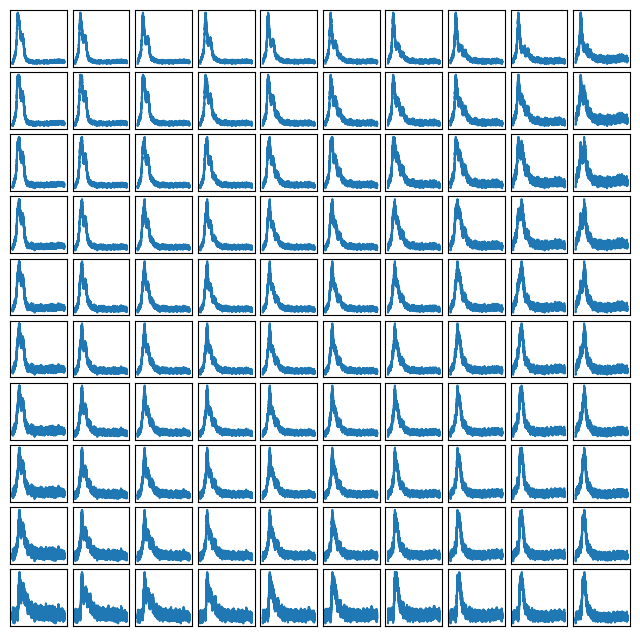

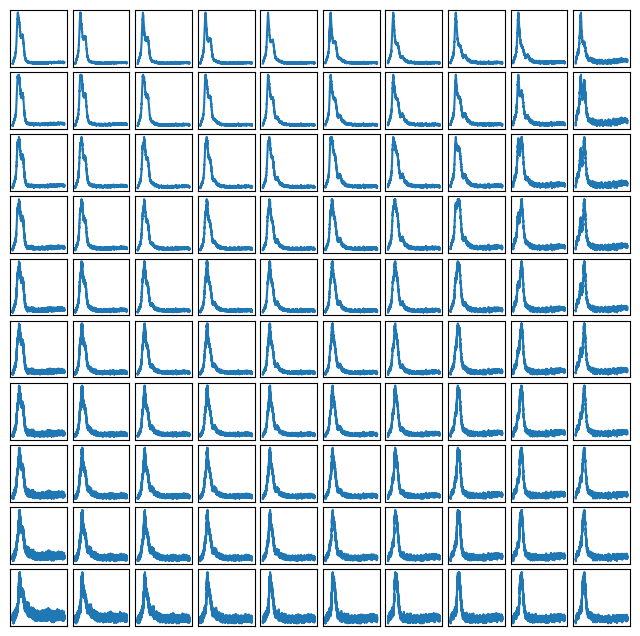

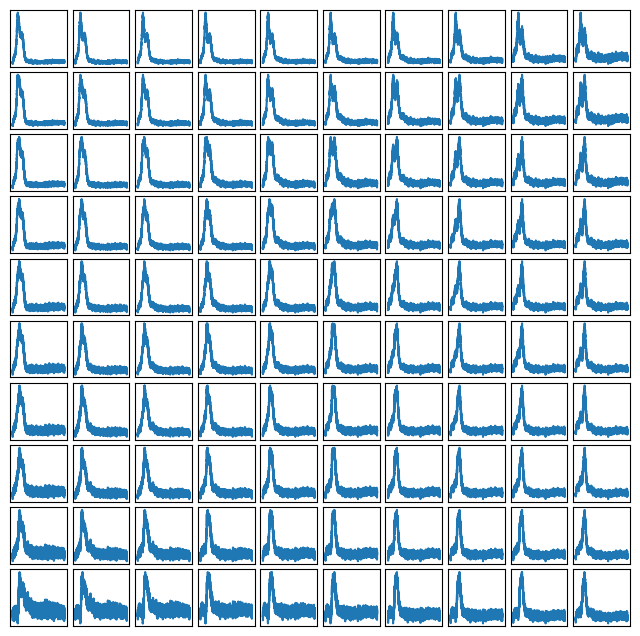

In [ ]:
for i in range(3):
    ssvae.manifold2d(10, label=i) #ylim=[0.25, 0.33]

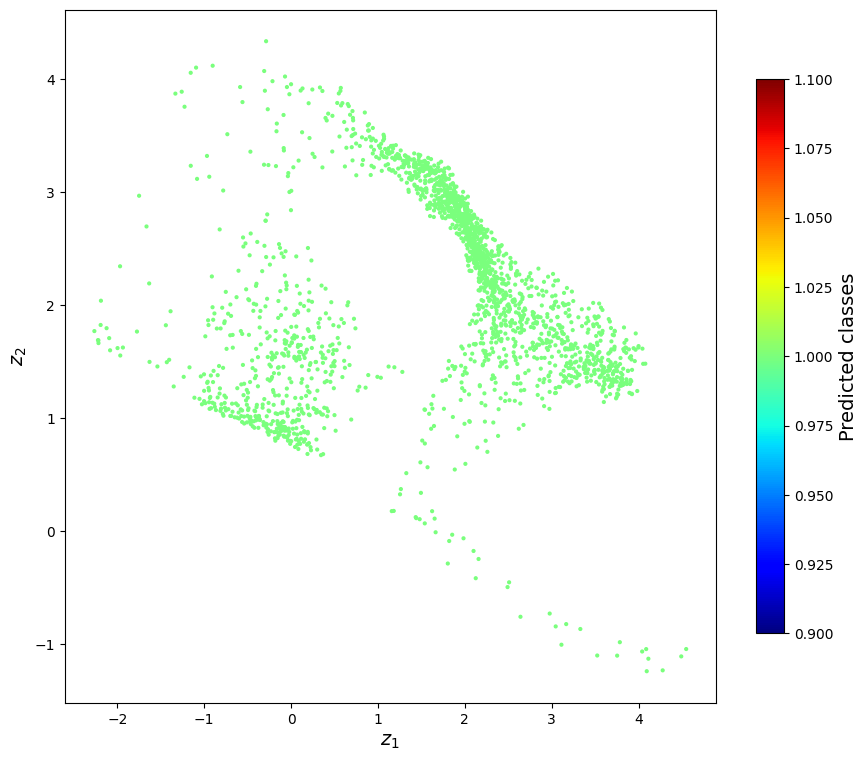

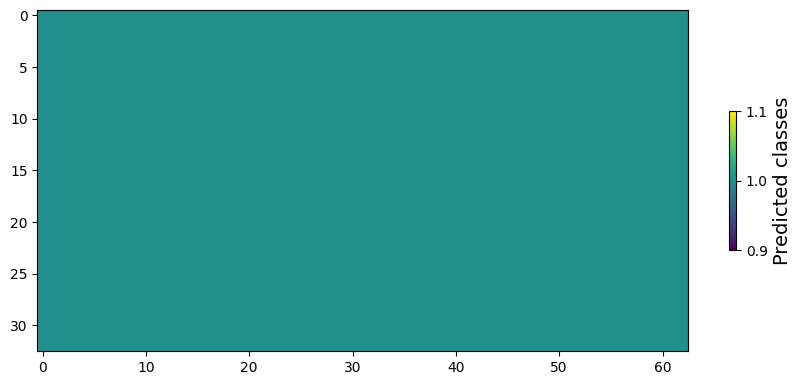

In [ ]:
z_mean, z_sd, y_pred = ssvae.encode(torch.tensor(X_train.reshape(d1*d2,d3)).float())

# one-hot to labels (for plotting)
_, labels = torch.max(y_sup, dim=1)

# Plot with predicted labels
fig, ax1 = plt.subplots(1, 1, figsize =(10.5, 9))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=y_pred, s=4, cmap='jet')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Predicted classes", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
plt.show()

fig, ax2 = plt.subplots(1, 1, figsize =(10.5, 9))
im2 = ax2.imshow(y_pred.reshape(d1,d2))
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.2)
cbar2.set_label("Predicted classes", fontsize=14)
cbar2.ax.tick_params(labelsize=10)
plt.show()

In [ ]:
print(z_mean.shape, z_sd.shape, y_pred.shape)
print(y_sup.shape)

torch.Size([2079, 2]) torch.Size([2079, 2]) torch.Size([2079])
torch.Size([57, 3])


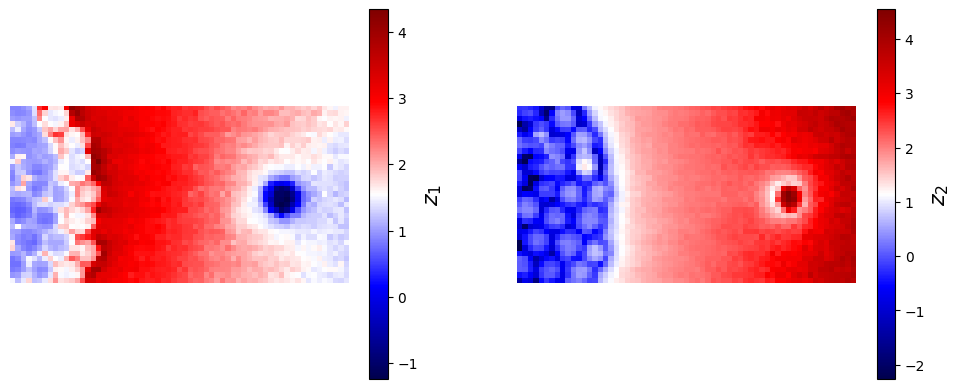

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(z_mean[:, 0].reshape(s1,s2), cmap='seismic')
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$z_1$", fontsize=16)
im2 = ax2.imshow(z_mean[:, 1].reshape(s1,s2), cmap='seismic')
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$z_2$", fontsize=16)

- For k = 2 image, results seem to be simialr to the conditioned on 0-order PCA component

# Supervised regression

Just for comparison, we add the supervise dlinear regression. This is very simple analysis method where we represent data set as linear combination of predefined components. It is not even ML, but interestingly it produces great results in some cases (and in cases when we expect image formation mechanism to be linear, and end members are known, it will be precise).

In [ ]:
'''
coordinates_surf = np.array([[i+10,j+10] for i in range(20) for j in range(20)])

plt.figure(figsize=(8, 3))
plt.imshow(im0, cmap=plt.cm.gray)
plt.plot(coordinates_surf[:, 1], coordinates_surf[:, 0], 'r.')
plt.axis('off')
plt.title('Label surface')
'''

"\ncoordinates_surf = np.array([[i+10,j+10] for i in range(20) for j in range(20)])\n                      \nplt.figure(figsize=(8, 3))\nplt.imshow(im0, cmap=plt.cm.gray)\nplt.plot(coordinates_surf[:, 1], coordinates_surf[:, 0], 'r.')\nplt.axis('off')\nplt.title('Label surface')\n"

(33, 63, 4322)


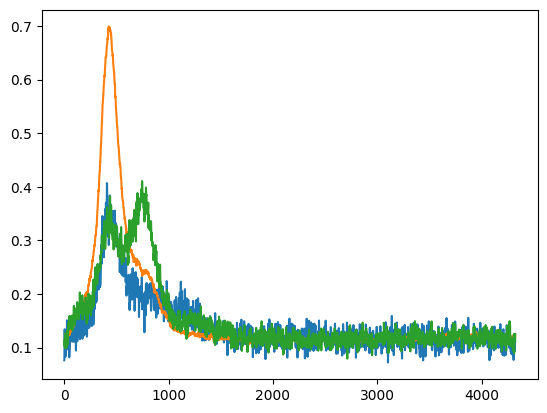

In [ ]:
X_vec2 = X_vec.reshape(s1,s2,s3)
print(X_vec2.shape)

#surf = np.array([X_vec2[i,j,:] for i,j in coordinates_surf]).mean(axis = 0)
defect0 = np.array([X_vec2[i,j,:] for i,j in coordinates0]).mean(axis = 0)
defect1 = np.array([X_vec2[i,j,:] for i,j in coordinates1]).mean(axis = 0)
defect2 = np.array([X_vec2[i,j,:] for i,j in coordinates2]).mean(axis = 0)

plt.plot(defect0)
plt.plot(defect1)
plt.plot(defect2)
# plt.plot(surf)

In [ ]:
from scipy.optimize import curve_fit
import scipy

def fn(x, a, b, c):
    return a*defect0 + b*defect1 + c*defect2

X_vec2 = X_vec2.reshape(d1*d2, d3)
ans_arr = []

for i, Xv in enumerate(X_vec2):
  popt, pcov = curve_fit(fn, np.arange(101), Xv)
  ans_arr.append(popt)

(2079, 3)


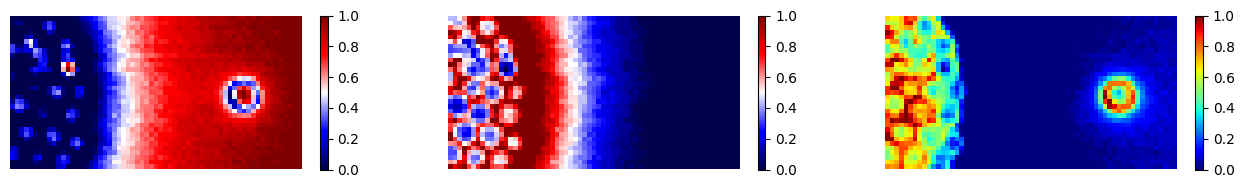

In [ ]:
ans_arr = np.array(ans_arr)
print(ans_arr.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4), dpi=100)

im1 = ax1.imshow(ans_arr.reshape(d1,d2,3)[:,:,0], cmap='seismic', vmin = 0, vmax = 1)
ax1.axis(False)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.5)

im2 = ax2.imshow(ans_arr.reshape(d1,d2,3)[:,:,1], cmap='seismic', vmin = 0, vmax = 1)
ax2.axis(False)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.5)

im3 = ax3.imshow(ans_arr.reshape(d1,d2,3)[:,:,2], cmap='jet', vmin = 0, vmax = 1)
ax3.axis(False)
cbar3 = fig.colorbar(im3, ax=ax3, shrink=.5)

plt.show()

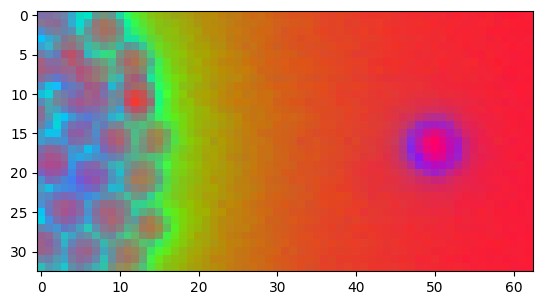

In [ ]:
normalize_func2 = lambda x: (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
plt.imshow(normalize_func2(ans_arr).reshape(d1,d2,3))

As you can see, it actually works pretty good!
